In [1]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

#레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

!pip install catboost
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker

!pip install pdpbox
from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Dataset

In [3]:
df_bus = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/bus_bts.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/submission_sample.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/train.csv')

## 데이터 이해하기 
1. 데이터의 사이즈는 ? 
  1.1 모델 학습에 적합한 형태인가?
2. Train/Test는 어떻게 분리되어 있는가?
3. Missing Value는?
4. Target Variable의 분포는?
5. 데이터의 특이한/주목해야할 부분은?

In [99]:
# Train/Test-set을 각각 체크해봅니다.
display(train.head(3))
display(test.head(3))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,0,1,321,1481,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,0,1,334,1822,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,0,1,407,1406,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. 데이터의 사이즈는? 

In [100]:
print('Train-set : {}'.format(train.shape))
print('Test-set : {}'.format(test.shape))

Train-set : (415423, 21)
Test-set : (228170, 20)


In [101]:
# Train-set에만 있는 칼럼은?

train.columns.difference(test.columns)

Index(['18~20_ride'], dtype='object')

### 2. Train/Test는 어떻게 분리되어 있는가?

#### 1. id에 차이가 있는가?

--> id는 Train/Test-set 각각의 key로 사용됨. 특별한 의미를 지니지 않고 테이블의 각 row를 구분짓는데만 사용되기에 모델링 시 제거해줘야하는 column

In [102]:
# Train-set의 id는?
print(train['id'].agg(['min', 'max']) )
print('Size : {}'.format(len(train)))

min         0
max    415422
Name: id, dtype: int64
Size : 415423


In [103]:
# Test-set의 id는?
print(test['id'].agg(['min', 'max']) )
print('Size : {}'.format(len(test)))

min    415423
max    643592
Name: id, dtype: int64
Size : 228170


#### 2. date에 차이가 있는가?

--> 맞다. 전체 데이터는 시간을 기준으로 Train/Test-set으로 나뉘어졌다.

- 2019-09-01 ~ 2019-09-30에 해당하는 데이터는 Train-set
- 2019-10-01 ~ 2019-10-16에 해당하는 데이터는 Test-set

In [104]:
# Train-set의 date는?
print(train['date'].agg(['min', 'max']) )
print('Size : {}'.format(len(train)))

min    2019-09-01
max    2019-09-30
Name: date, dtype: object
Size : 415423


In [105]:
# Test-set의 date는?
print(test['date'].agg(['min', 'max']) )
print('Size : {}'.format(len(test)))

min    2019-10-01
max    2019-10-16
Name: date, dtype: object
Size : 228170


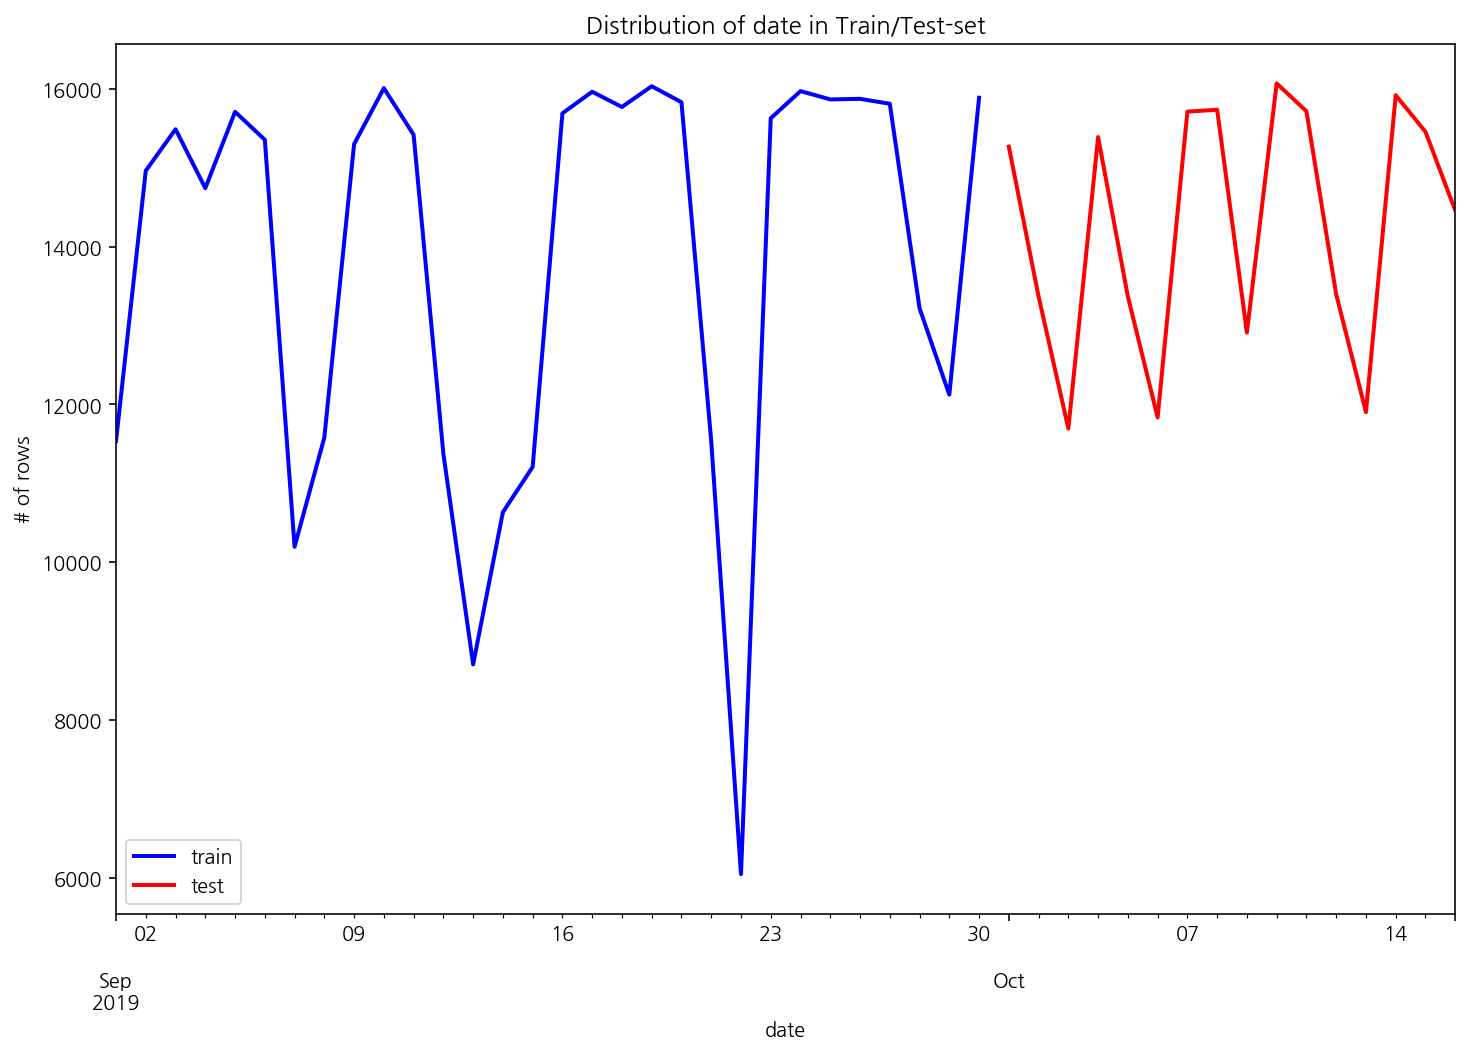

In [106]:
# Train/Test의 date 분포는?
plt.figure(figsize = (12,8))

pd.to_datetime(train['date']).value_counts().sort_index().plot(color='b', lw=2, label='train')
pd.to_datetime(test['date']).value_counts().sort_index().plot(color='r', lw=2, label='test')

plt.legend()
plt.xlabel("date")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-set");

# 평균적으로 탑승객이 어떤 식으로 분포되어있는지 살펴보자.
# 굉장히 떨어지는 지점이 특별한 공휴일은 아닌지 살펴보자.

#### 3. 정류장에 차이가 있는가?

--> 큰 차이는 없다. 

다만,
- Train-set에는 있지만, Test-set에는 없는 bus_route_id가 30개 존재하며
- Test-set에는 있지만,  Train-set에는 없는 bus_route_id가 18개 존재한다.

Train-set에 등장하지 않으나, Test-set에 등장하는 경우 모델은 학습되지 않은 데이터를 가지고 예측을 해야하는 문제가 있다.

해당 부분들을 어떻게 보완할 지 생각보는 것도 좋을 듯하다.

--> 아래에서 확인할 수 있듯이, Test-set에만 등장하는 bus_route_id는 Train/Test-set 모두에 등장하는 bus_route_id보다 평균 탑승승객수가 적은 경향이 있는 듯이 보인다.

--> 해결책 중 하나로, Train-set기간동안에 해당 bus_route_id의 퇴근 시간의 탑승 승객수를 "0"으로 레이블링하여 새로운 row를 추가할 수 있을 것이다.

In [107]:
display(train.head(3))
display(test.head(3))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,0,1,321,1481,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,0,1,334,1822,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,0,1,407,1406,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
# Train/Test-set의 고유한 bus_route_id를 구함.
train_bus_route_id_set = set(train['bus_route_id'])
test_bus_route_id_set  = set(test['bus_route_id'])

In [109]:
# Train/Test-set 고유한 bus_route의 개수를 구함.
print('Train-set에 있는 고유한 bus_route의 개수 : {}'.format( len( train_bus_route_id_set) ))
print('Test-set에 있는 고유한 bus_route의 개수 : {}'.format( len( test_bus_route_id_set) ))

Train-set에 있는 고유한 bus_route의 개수 : 613
Test-set에 있는 고유한 bus_route의 개수 : 601


In [110]:
# Train/Test-set 모두에 포함되어있는 bus_route를 구함.
common_bus_route_id = train_bus_route_id_set.intersection( test_bus_route_id_set )
print('Train/Test-set에 공통으로 포함되어 있는 bus_route 개수 : {}'.format( len(common_bus_route_id) ))

Train/Test-set에 공통으로 포함되어 있는 bus_route 개수 : 0


In [111]:
# Train-set에만 있는 bus_route를 구함. 
only_train_bus_route = train_bus_route_id_set.difference( test_bus_route_id_set ) 
print( 'Train-set에만 있는 bus_route 개수 : {}'.format (len( only_train_bus_route) ))

only_test_bus_route = test_bus_route_id_set.difference( train_bus_route_id_set ) 
print ('Test-set에만 있는 bus_route 개수 : {}'.format(len( only_test_bus_route)))

Train-set에만 있는 bus_route 개수 : 613
Test-set에만 있는 bus_route 개수 : 601


In [112]:
# 탑승 관련 columns & 하차 관련 columns
ride_columns = [col for col in test.columns if '_ride' in col] + ['bus_route_id','date']
take_off_columns = [col for col in test.columns if '_takeoff' in col] + ['bus_route_id','date']

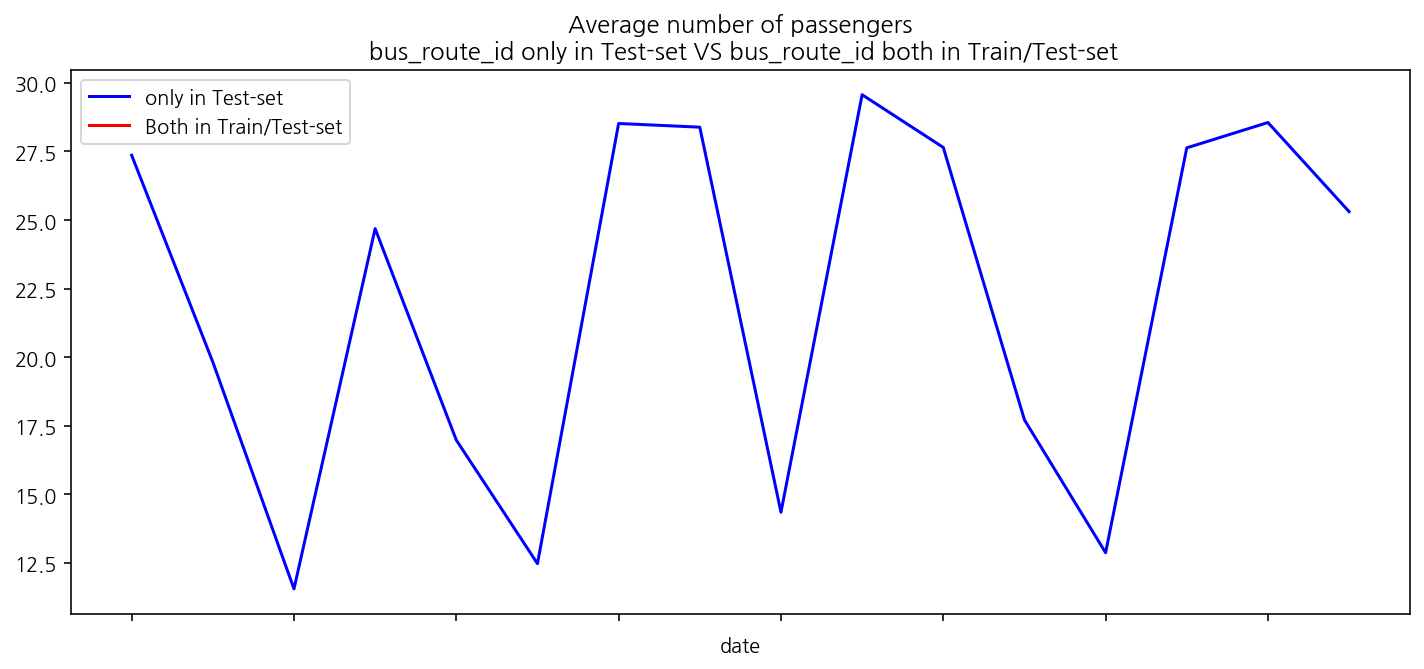

In [113]:
# 두 경우의 탑승 관련 columns 비교
plt.figure(figsize=(12,5))
test[test['bus_route_id'].isin( only_test_bus_route)][ride_columns].groupby(['date', 'bus_route_id'])['8~9_ride'].sum().groupby('date').mean().plot(color='b', label='only in Test-set')
test[test['bus_route_id'].isin( common_bus_route_id)][ride_columns].groupby(['date', 'bus_route_id'])['8~9_ride'].sum().groupby('date').mean().plot(color='r', label='Both in Train/Test-set')
plt.legend()
plt.title('Average number of passengers\n bus_route_id only in Test-set VS bus_route_id both in Train/Test-set');

### 3. Missing Value는 존재하는가?

--> 존재하지 않는다

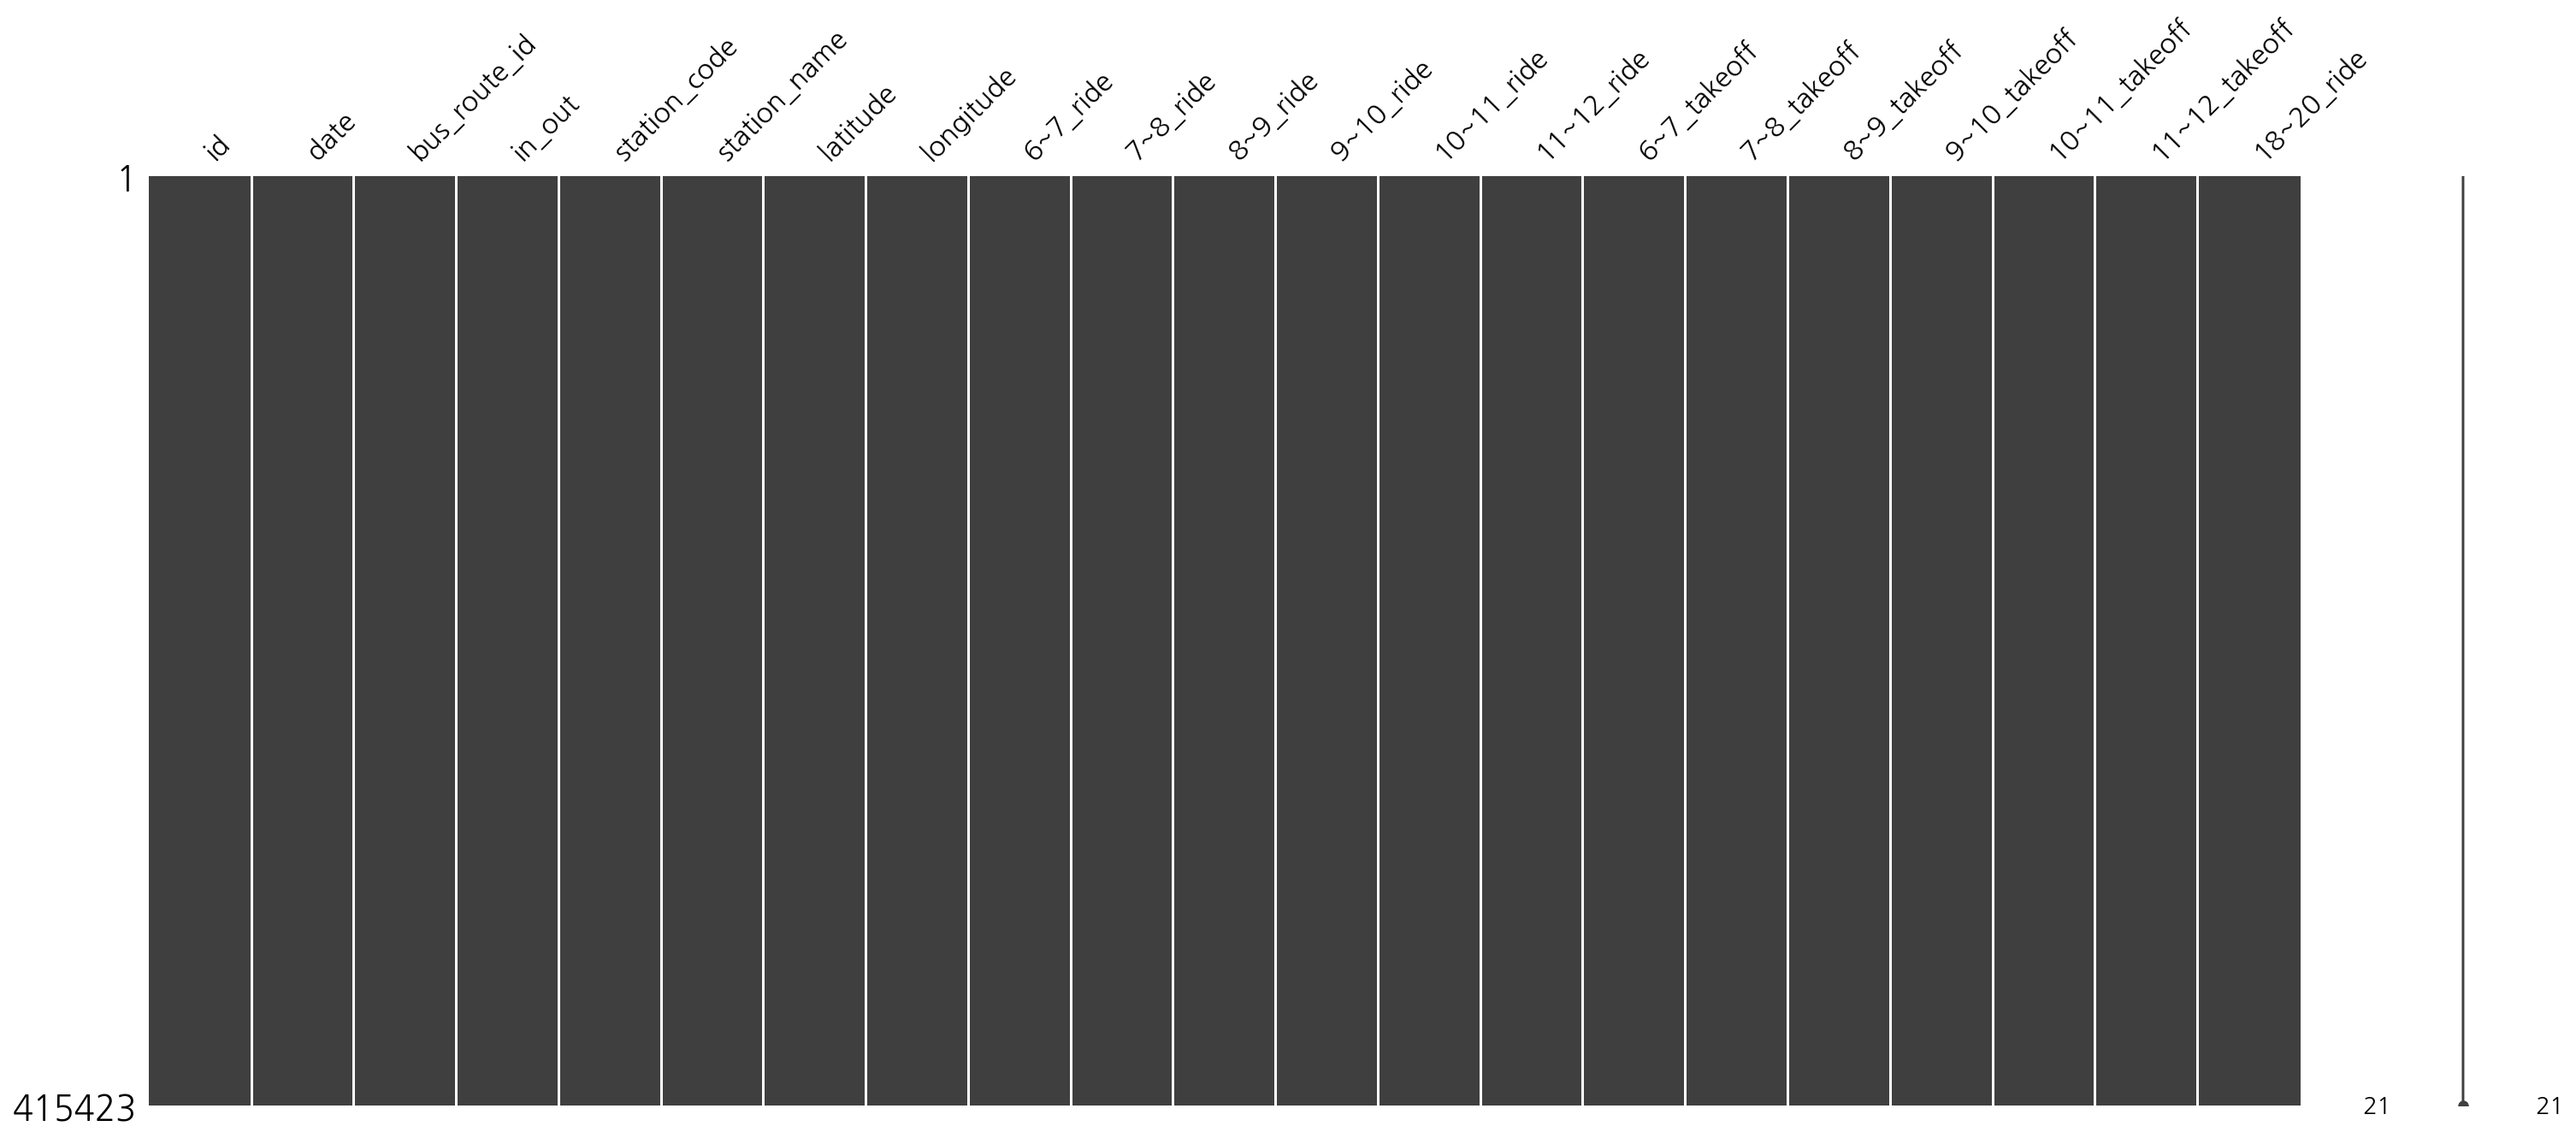

In [114]:
# Missing Values
msno.matrix(train)

In [115]:
print("Train-set")
display(train.isnull().sum())

print('=' * 80)

print("Test-set")
display(test.isnull().sum())

Train-set


id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

Test-set


id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64

### 4. Target Variable의 분포는?

In [116]:
# Target Variable의 분포를 살펴보자
target_col = '18~20_ride'
train[ target_col].value_counts().sort_index()

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
5.0        5911
6.0        4291
7.0        3152
8.0        2288
9.0        1865
10.0       1409
11.0       1183
12.0        996
13.0        807
14.0        660
15.0        597
16.0        508
17.0        450
18.0        408
19.0        394
20.0        331
21.0        261
22.0        234
23.0        218
24.0        198
25.0        168
26.0        194
27.0        150
28.0        144
29.0        132
30.0        113
31.0         94
32.0         80
33.0         79
34.0         77
35.0         78
36.0         58
37.0         61
38.0         64
39.0         53
40.0         37
41.0         51
42.0         43
43.0         41
44.0         52
45.0         37
46.0         32
47.0         35
48.0         21
49.0         28
50.0         26
51.0         24
52.0         21
53.0         24
54.0         22
55.0         22
56.0         20
57.0         17
58.0         21
59.0         13
60.0         16
61.0         20
62.0    

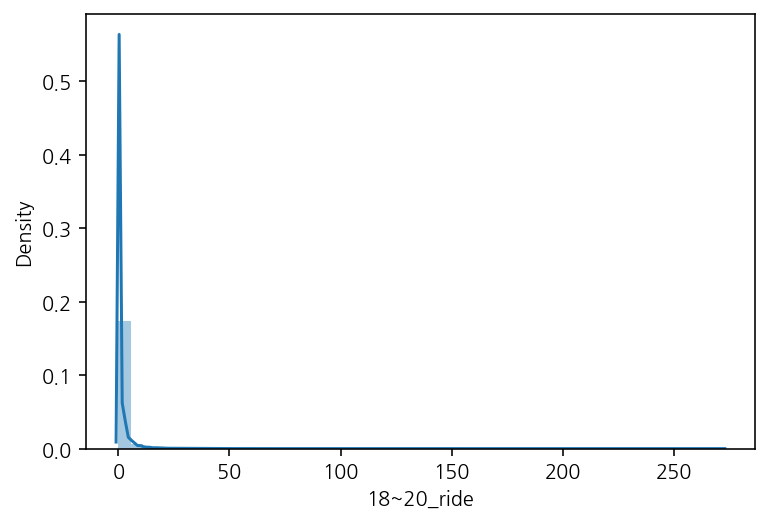

In [117]:
# Dist-plot을 그려보도록 한다.
# --> (1) 0이 굉장히 많다. 
# --> (2) right-skewed된 형태이며, 값이 매우 큰 outlier들이 존재한다.
sns.distplot( train[target_col] );

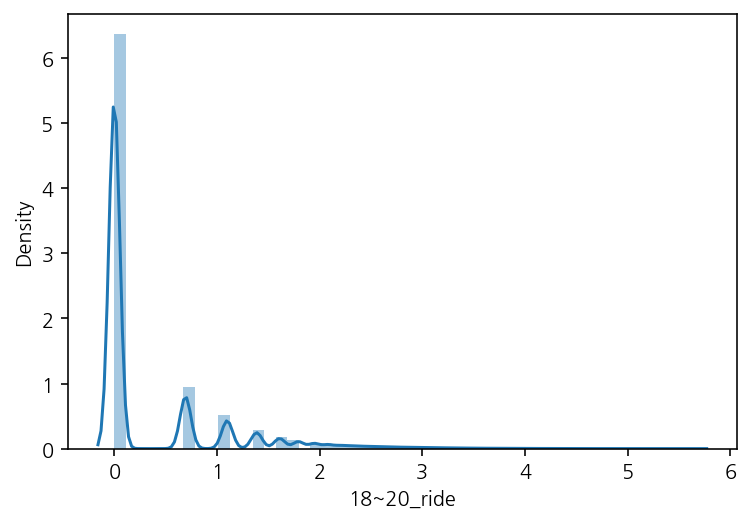

In [118]:
# log1p transformation을 적용해봐도 정규분포에 근사한 모양을 보이지 않는다.
sns.distplot( np.log1p( train[target_col] ) );

####  1. Target Variable이 0인 데이터는 어떤 특징을 가지고 있는가?

--> 테이블에 적재된 row들은 해당 승차/하차 관련 칼럼들의 rowsum이 1이상인 데이터
--> 퇴근시간에 승차한 승객이 있더라도 승차/하차 관련 칼럼들의 rowsum이 0인 경우는 우리가 볼 수 있는 테이블에 적재되지 못하였다.

--> 나중에 data-augmentation을 시도하고자 하는 경우 유용한 정보가 될 수도..?

In [119]:
# 탑승 관련 columns & 하차 관련 columns
ride_columns = [col for col in test.columns if '_ride' in col]
take_off_columns = [col for col in test.columns if '_takeoff' in col] 

In [120]:
# Train-set의 승차관련 칼럼들의 rowsum 
display( train[train[target_col]==0][ride_columns].sum(axis=1).agg(['min', 'max']))
print('=' * 80)

# Train-set의 하차관련 칼럼들의 rowsum 
display( train[train[target_col]==0][ take_off_columns].sum(axis=1).agg(['min', 'max']))
print('=' * 80)

# Train-set의 승하차관련 칼럼들의 rowsum 
display( train[train[target_col]==0][ride_columns+ take_off_columns].sum(axis=1).agg(['min', 'max']))

min      0.0
max    138.0
dtype: float64

min      0.0
max    165.0
dtype: float64

min      1.0
max    283.0
dtype: float64

### 5. 데이터의 특이한/주목해야할 부분은?

1. 해당 버스정류장에 대한 각각의 위도, 경도가 제공이 되어있는 상태로 같은 정류장 이름이지만 위도와 경도가 서로 다른 경우가 존재합니다. 해당 경우는, 같은 정류장 이름을 가지고 있는 길 건너편의 정류장에 해당이 됩니다.

1. 해당 데이터에는 버스카드를 통해 결제를 한 경우에 대한 정류소 승, 하차 데이터로 모든 승차정보의 경우는 기록이 되어있지만, 버스에서 하차를 할 때, 버스카드를 찍지 않는 경우, 해당 기록이 비어 있는 상태입니다. 따라서, 승차 인원수와 하차 인원수가 동일하지 않고 다소 차이가 있음을 미리 알려드립니다.

#### 1. 같은 정류장 이름이 여러 번 나오는 경우?

In [121]:
# (1)의 경우에는 어떤 것들이 있나 예시를 통해 살펴보도록 하자
# 하나의 station_name에 여러 개의 station_code가 기록되어 있는 경우는 어떤 상황인가?
multiple_station_name = train.groupby('station_name')['station_code'].nunique()
multiple_station_name = multiple_station_name[multiple_station_name>=7]
print(multiple_station_name)

df_sample = train[train['station_name'].isin(multiple_station_name.index)][['station_code','station_name','latitude','longitude']]
df_sample = df_sample.drop_duplicates().reset_index(drop=True) # drop=True, 기존 인덱스가 컬럼으로 더해지는 것을 방지 
df_sample

station_name
203     7
1001    8
Name: station_code, dtype: int64


,station_code,station_name,latitude,longitude
0,341,1001,33.51912,126.63493
1,787,1001,33.51037,126.63498
2,789,1001,33.51734,126.63563
3,340,1001,33.51957,126.63523
4,873,203,33.36658,126.28713
5,867,203,33.35763,126.29492
6,2703,1001,33.51493,126.63479
7,2704,1001,33.51500,126.63504
8,661,203,33.35743,126.29466
9,786,1001,33.51007,126.63523


In [ ]:
def generateMap(default_location=[33.35098, 126.79807], default_zoom_start=10):
    base_map = folium.Map(location=default_location, 
                          control_scale=True, 
                          zoom_start=default_zoom_start)
    
    # 여러 개의 정거장에 대해서 Icon 생성하기
    for row in df_sample.itertuples():
        station_code, station_name, latitude, longitude = row[1:]
        
        # Create Icon
        if station_name == '금악리':
            icon = Icon(color='red',icon='station')
        else:
            icon = Icon(color='blue',icon='station')
                
        # Add Marker
        Marker(location=[ latitude , longitude], 
               popup=f'station_code : {station_code} station_name : {station_name}',
               icon = icon).add_to(base_map)
        
    
    base_map.save('하나의 station_name에 여러개의 station_code.html')
    return base_map

generateMap()

#### 1.1 고유한 정거장의 기준은?

다음으로 `고유한 정거장`을 어떻게 분리할 수 있는지 알아보도록 하겠습니다.

먼저 `고유한 정거장`은 아래와 같은 조건을 만족해야한다고 생각합니다.

    1. 위경도가 1개여야한다.
    2. 시내버스 혹은 시외버스 1개의 노선만 있어야 한다.
    3. 특정 날짜에 특정 노선에서 특정 정거장의 승객 수를 기록한 row는 1개여야 한다.

####  **station_name를 기준으로 삼는다면?**

--> station_name에는 여러개의  station_code가 매핑되어있음 & 여러 개의 위치 정보를 갖는 것으로 보임

--> 고유한 정거장의 기준을 station_name으로 잡기에는 어려워보임

In [123]:
display( train.groupby('station_name')['station_code'].nunique().value_counts() )

2    1308
1     540
3      60
4      45
5       4
6       2
7       1
8       1
Name: station_code, dtype: int64

In [124]:
# station_name를 기준으로 삼는다면?
# --> 하나의 station_name가 여러 개의 latitude, longitude를 갖는 것으로 보임
display(train.groupby('station_name')['latitude'].nunique().value_counts())
print('='*80)
display(train.groupby('station_name')['longitude'].nunique().value_counts())

2    1283
1     566
3      59
4      45
5       4
6       2
7       1
8       1
Name: latitude, dtype: int64

2    1291
1     560
3      58
4      45
5       3
7       2
6       2
Name: longitude, dtype: int64

#### station_code는 어떨까?

--> 적합하다고 생각된다.

따라서 "특정 날짜"에 "특정 버스 노선"의 "특정 정거장"에서 "몇 명의 승객이 승하차했는지"를 파악하기 위해선
`date, bus_route_id, station_code`로 그룹화를 시켜서 파악해야 한다.

In [125]:
# station_code를 기준으로 삼는다면?
# --> station_code에는 1개의  station_name이 매핑되어있음.
display(train.groupby('station_code')['station_name'].nunique().value_counts())

1    3563
Name: station_name, dtype: int64

In [126]:
# station_code를 기준으로 삼는다면?
# --> station_code는 latitude, longitude와 1대1 관계를 만족함
display( train.groupby('station_code')['latitude'].nunique().value_counts() )
display( train.groupby('station_code')['longitude'].nunique().value_counts() )

1    3563
Name: latitude, dtype: int64

1    3563
Name: longitude, dtype: int64

In [127]:
# station_code를 기준으로 삼는다면?
# --> station_code는 in_out와 1대1 관계를 만족함
display( train.groupby('station_code')['in_out'].nunique().value_counts() )

1    3563
Name: in_out, dtype: int64

In [128]:
# date, bus_route_id, station_code이 특정 날짜에 몇번 등장했는지 재확인하기 
display( train.groupby(['date','bus_route_id','station_code']).size().value_counts() )
print('='* 80)
print(f'Train-set size : {len(train)}')

1    415423
dtype: int64

Train-set size : 415423


## Validation 전략

시간을 기준으로 앞의 3주를 local_train으로, 뒤의 1주를 local_test를 만들어 본다.

1. local_train을 통하여 validation 전략을 실험해보고
2. 해당 모델로 local_test의 값을 예측한 값이 어느정도 차이가 나는지 살펴본다.

In [173]:
# local_train/local_test를 만든다.
local_train = train[train['date']<='2019-09-24'].reset_index(drop=True)
local_test  = train[train['date']>'2019-09-24'].reset_index(drop=True) 

In [174]:
display(local_train.head(1))
display(local_test.head(1))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,dawn_ride,morning_ride,noon_ride,dawn_takeoff,morning_takeoff,noon_takeoff
0,0,2019-09-01,0,1,322,1489,33.4899,126.49373,0.0,1.0,7.0,8.0,0.0,0.0,0.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,dawn_ride,morning_ride,noon_ride,dawn_takeoff,morning_takeoff,noon_takeoff
0,326655,2019-09-25,0,1,322,1489,33.4899,126.49373,1.0,8.0,2.0,1.0,0.0,0.0,0.0


In [175]:
# categorical variable인 'bus_route_id','in_out','station_code','station_name' 에 대해선 label_encoding을 적용해주고,
# numeric variable들에 대해선 있는 그대로 학습을 시켜보도록 한다.
lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    # local_train과 local_test를 concat하여 temp_df에 저장
    temp_df = pd.concat([ local_train[[col]], local_test[[col]] ] , axis=0)
    
    # Label-Encoding을 fitting함
    lbl.fit( temp_df[col] )
    
    # local_train/local_test에 label_encoding한 값을 대입함
    local_train[col] = lbl.transform(local_train[col])
    local_test[col] = lbl.transform(local_test[col])

  0%|          | 0/4 [00:00<?, ?it/s]

In [132]:
display(local_train.head(1))
display(local_test.head(1))

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,0,1,321,1481,33.4899,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,326655,2019-09-25,0,1,321,1481,33.4899,126.49373,5.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### LightGBM을 통하여 모델링 하기

-> LOCAL_TRAIN에 해당하는 부분보다 LOCAL_TEST에 해당하는 부분의 예측력이 떨어지는 모습을 보인다.

-> 실제 값보다 예측 값이 지나치게 큰 경우들이 존재하는데, 해당 경우들이 어떤 것들인지 살펴봐야겠다.

-> 아래와 같은 다른 validation 기법들도 고려해볼 수 있을 것이다.
 - HOLD OUT
 - GROUP FOLD BY weekofmonth 

-> 본 강의에서는 KFOLD를 가지고 baseline model을 만들어 보기로 한다.

In [133]:
# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt', # 가장 많이 쓰는 게 그라디언트 부스팅 트리 
              'random_state':1993,
              'learning_rate':0.3, # 모델 학습을 얼마나 빠르게 진행할거냐 
              'subsample':0.7, # 전체 학습 데이터 중 몇 퍼센트 데이터를 사용할 것인가? 서브 샘플링을 낮추면 오버피팅을 방지 할 수 있다
              'tree_learner': 'serial', # 트리 학습기 
              'colsample_bytree':0.78, # 여러 개의 칼럼 중 몇 퍼센트를 사용할 것인가? 컬럼의 개수가 1000개, 2000개 되면 과감하게 0.3, 0.2
              'early_stopping_rounds':50, # train set의 loss는 지속적으로 감소하지만, validation의 loss가 하락하지 않을 경우 50 iteration이 넘었을 때 학습 중단 
              'subsample_freq': 1,
              'reg_lambda':7, # 정규화, 보통 1,2,3, 오버피팅을 방지하고자 할때 값을 높게 설정 
              'reg_alpha': 5, # 정규화, 보통 1,2,3, 오버피팅을 방지하고자 할때 값을 높게 설정 
              'num_leaves': 96,
              'seed' : SEED
            }

In [176]:
# 제거해야 하는 columns 정의 
drop_cols = ['id', 'date', target_col]

# local_train/local_test에 대한 label 정의
local_train_label = local_train[target_col]
local_test_label  = local_test[target_col]

In [177]:
# local_train/local_test의 예측값을 저장하기 위한 OOF 만들기 & CV를 저장할 list 정의 
oof_train = np.zeros((local_train.shape[0],))
oof_test = np.zeros((local_test.shape[0],))

cv_list = []

# Kfold 정의
kfolds = KFold(n_splits=n_splits
               , random_state=1993, shuffle=True) # 여러 개의 모델을 만들어 앙상블할때 random_state를 똑같이 지정해야 함 

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = local_train, y = local_train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = local_train.iloc[trn_ind].drop(drop_cols, 1), local_train_label[trn_ind]
    X_valid , y_valid = local_train.iloc[val_ind].drop(drop_cols, 1), local_train_label[val_ind]
    
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100) # 몇번당 학습의 결과를 화면에 내보낼 것인가 
    
    # local_valid/local_test에 대한 예측
    valid_pred = model.predict(X_valid)
    test_pred  = model.predict( local_test.drop(drop_cols,1) )
    
    # CV를 저장
    cv_list.append( sqrt( mean_squared_error( y_valid, valid_pred )  ) )
    
    # OOF에 예측값을 저장
    oof_train[val_ind] = valid_pred
    oof_test += test_pred/n_splits # 학습이 진행 될 때마다 1/5만큼만 더해라 
    print('='*80)
    
print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( local_train_label, oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( local_test_label, oof_test ) )}")

0it [00:00, ?it/s]

Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.34013	valid's rmse: 2.76295
[200]	train's rmse: 2.10389	valid's rmse: 2.74295
[300]	train's rmse: 1.95722	valid's rmse: 2.72343
[400]	train's rmse: 1.84886	valid's rmse: 2.71699
Early stopping, best iteration is:
[445]	train's rmse: 1.80723	valid's rmse: 2.71068
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.34328	valid's rmse: 2.73387
[200]	train's rmse: 2.10399	valid's rmse: 2.71437
[300]	train's rmse: 1.96205	valid's rmse: 2.70933
[400]	train's rmse: 1.85441	valid's rmse: 2.70514
Early stopping, best iteration is:
[357]	train's rmse: 1.89796	valid's rmse: 2.70329
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.32837	valid's rmse: 2.91084
[200]	train's rmse: 2.09175	valid's rmse: 2.8965
Early stopping, best iteration is:
[192]	train's rmse: 2.10446	valid's rmse: 2.89016
Training until validation scores don't improve for 50 rounds

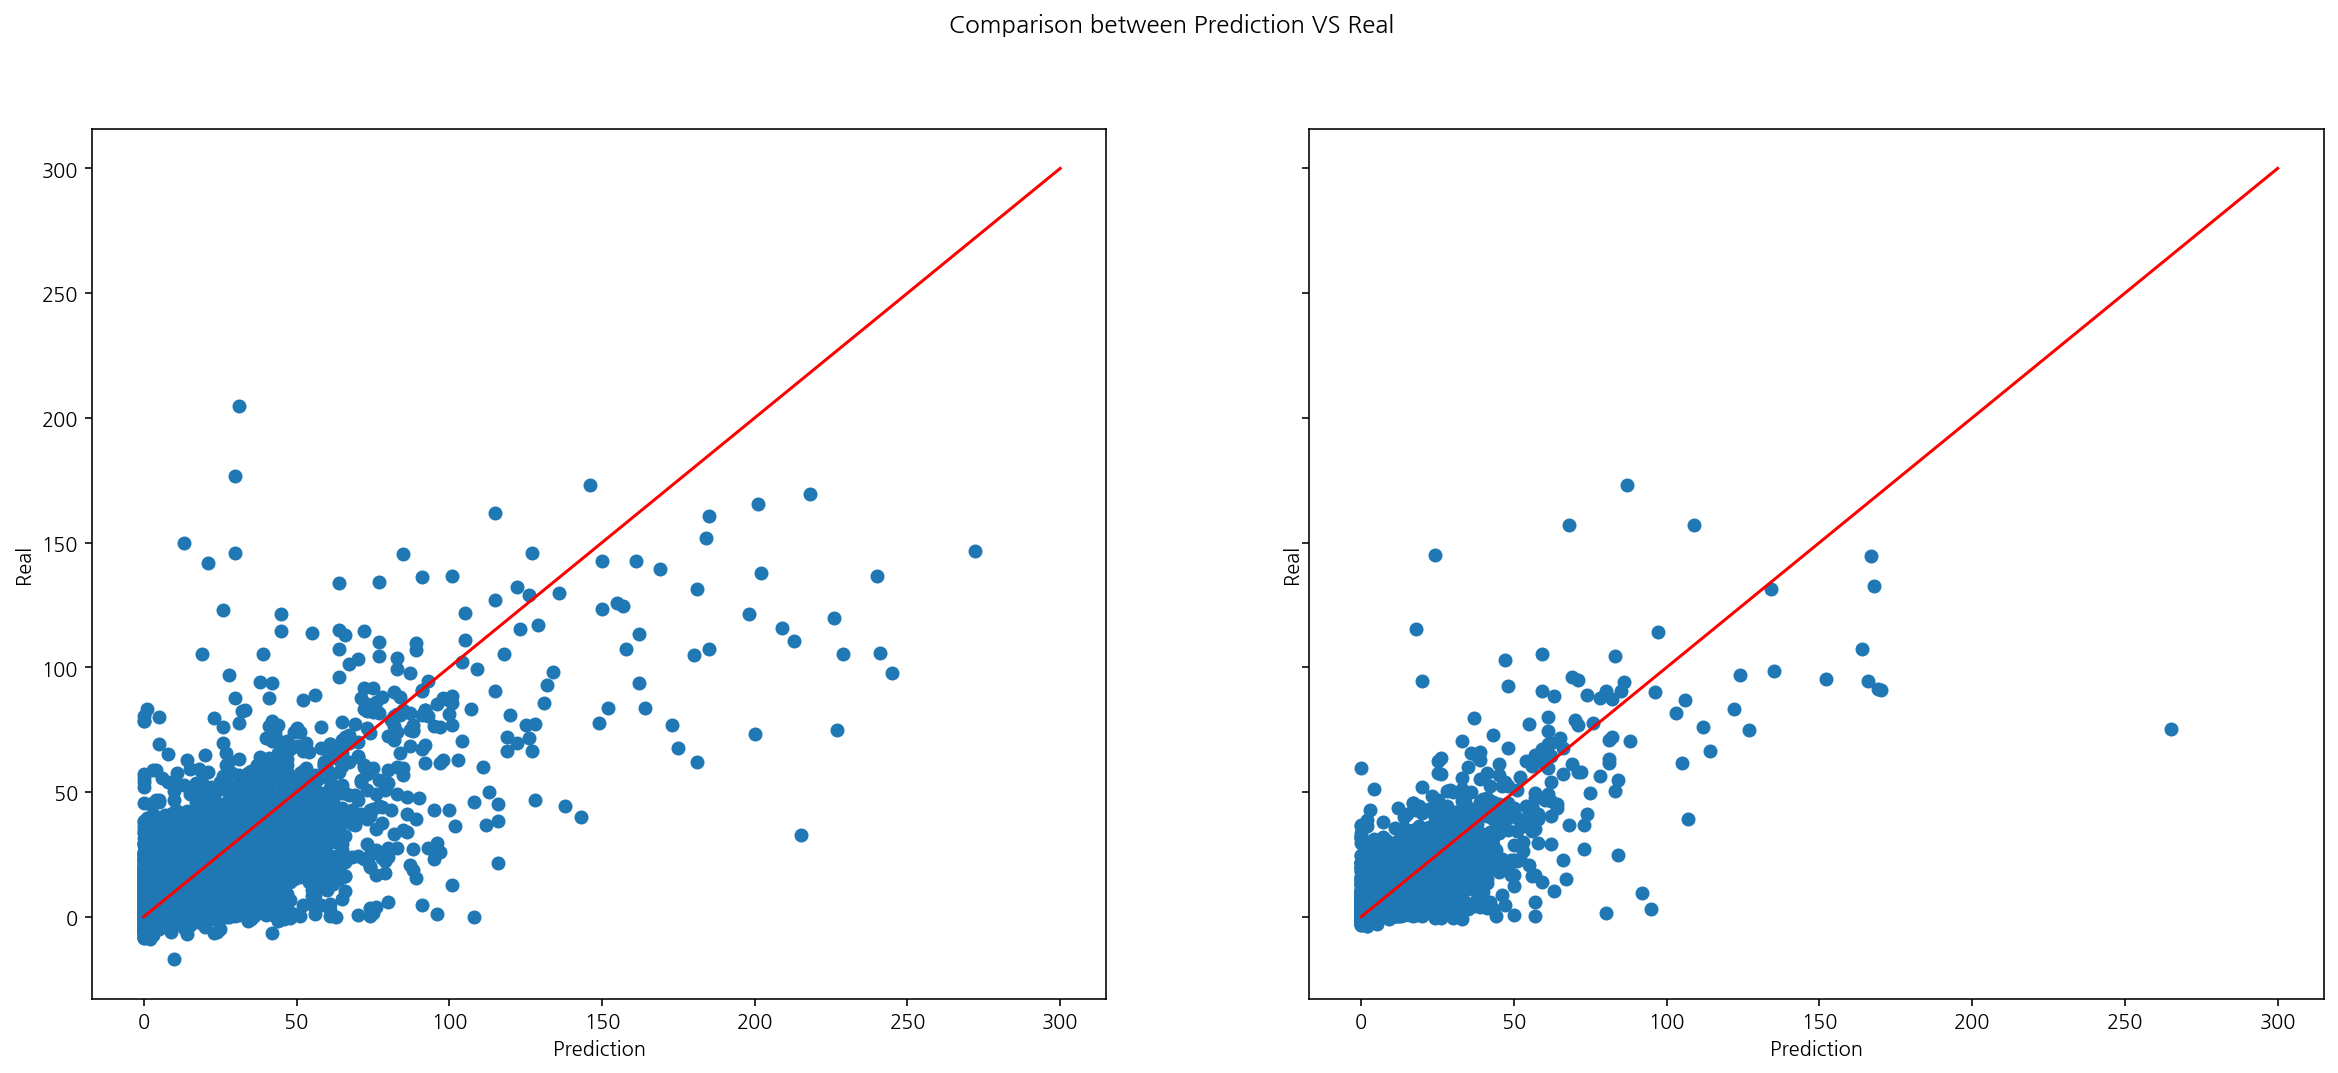

In [136]:
# 실제값과 예측값의 분포 비교 
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharex=True, sharey= True)

# y=x를 그리기 위하여 
x_range = np.linspace(0, 300, 1000) # 0에서 300까지 1000개의 요소로 만들어라 

# <SUBPLOT 1> : local_train에 대한 예측/실제값 비교
axes[0].scatter( local_train_label, oof_train )
axes[0].set_xlabel("Prediction")
axes[0].set_ylabel("Real")
axes[0].plot(x_range, x_range, color='r')

# <SUBPLOT 2> : local_test에 대한 예측/실제값 비교
axes[1].scatter( local_test_label, oof_test )
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Real")
axes[1].plot(x_range, x_range, color='r')

plt.suptitle('Comparison between Prediction VS Real');

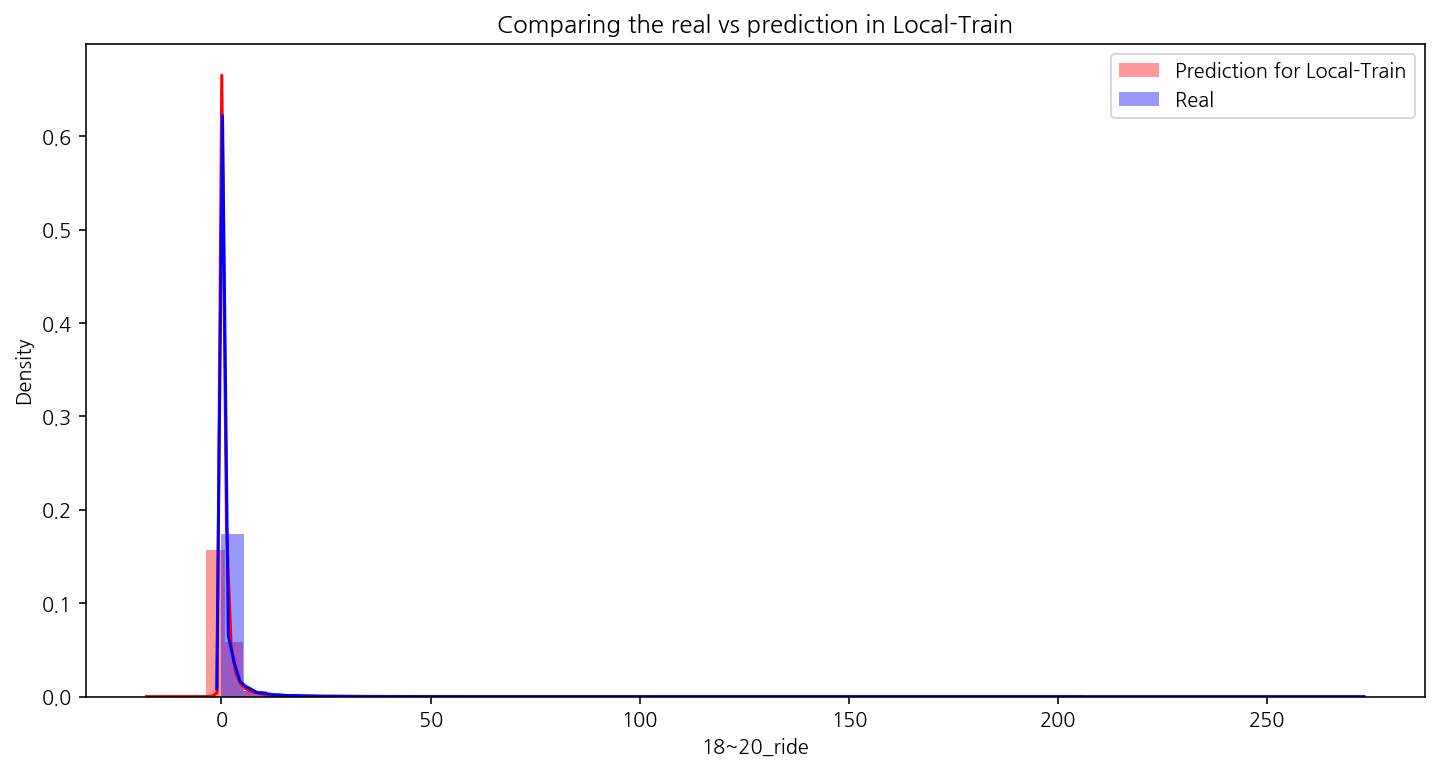

In [137]:
# 실제값 vs 예측값 비교
plt.figure(figsize=(12,6))

sns.distplot( oof_train, color='r' , label='Prediction for Local-Train')
sns.distplot( local_train_label, color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Train");

In [138]:
min(oof_train) # 0보다 작은 수에 대해서는 0으로 보정 

-16.972225679224387

In [139]:
min(local_train_label) # 최소 승객수 0 

0.0

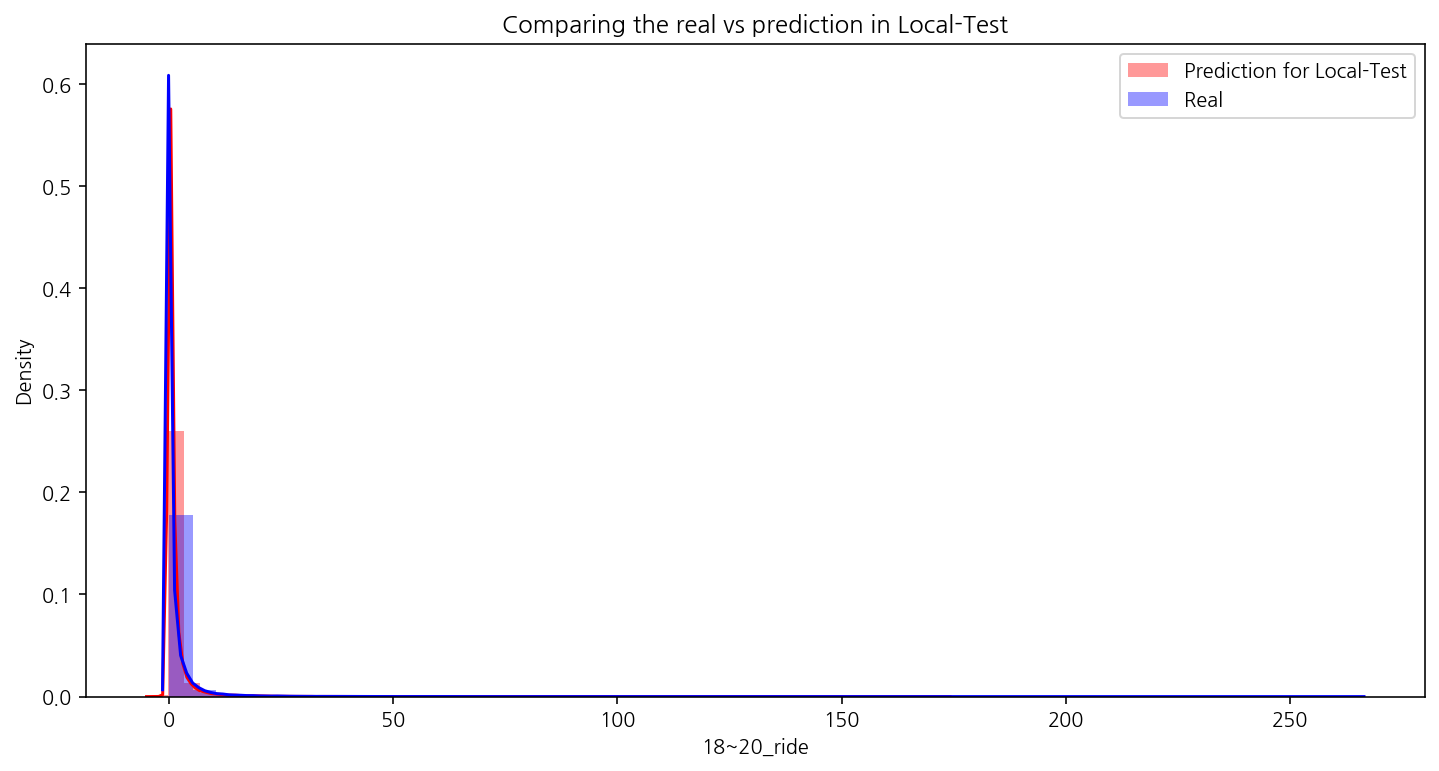

In [140]:
# 실제값 vs 예측값 비교
plt.figure(figsize=(12,6))

sns.distplot( oof_test, color='r' , label='Prediction for Local-Test')
sns.distplot( local_test_label, color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Test");

In [141]:
del local_train, local_test, local_train_label, local_test_label; 
gc.collect();

## BASELINE MODEL 만들기

아래와 같은 모델들을 만들어보고, 어떤 타입의 모델이 본 문제를 풀기 적합한가 살펴보도록 하자.
추가적으로 linear model에서는 coefficient를 통하여, tree-based model에서는 feature_importance를 통하여 변수의 중요도를 살펴보며,
향후 모델의 성능을 높이기 위해선 어떤 방법이 있을까 생각해보자.

1. 어떤 모델이 본 데이터에 적합할까? 
- Linear Regression : Ridge, Lasso     
- Tree-Based : Decision Tree, Random Forest, Light GBM

2. 모델 학습 시 어떤 column을 주목하였는가 
- Linear Regression : Coefficient
- Tree-Based : Feature Importance 

3. 특정 칼럼의 값이 변함에 따라 target variable은 어떤 영향을 받는가 (PDP Plot)

In [88]:
# train_label 정의
train_label = train[target_col]

In [89]:
# categorical variable에 대해서는 Label-Encoding을 수행 
# --> One-Hot Encoding가 바람직하다고 생각되나 메모리 문제로 실행할 수 없음.
lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    
    # Label-Encoding을 fitting함
    lbl.fit( train[col] )
    
    # local_train/local_test에 label_encoding한 값을 대입함
    train[col] = lbl.transform(train[col])

  0%|          | 0/4 [00:00<?, ?it/s]

In [90]:
# 각 모델에 대한 oof 정의 
ridge_oof_train = np.zeros((train.shape[0]))
lasso_oof_train = np.zeros((train.shape[0]))
dt_oof_train = np.zeros((train.shape[0]))
rf_oof_train = np.zeros((train.shape[0]))
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의 
Kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True) 

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # (1) Ridge
    print("---TRAINING RIDGE---")
    ridge = Ridge(random_state = 1993)
    
    ridge.fit(X_train, y_train)
    
    ridge_valid_pred = ridge.predict(X_valid)
    ridge_oof_train[val_ind] = ridge_valid_pred
    
    # (2) Lasso
    print("---TRAINING LASSO---")
    lasso = Lasso(random_state = 1993)
    
    lasso.fit(X_train, y_train)
    
    lasso_valid_pred = lasso.predict(X_valid)
    lasso_oof_train[val_ind] = lasso_valid_pred
    
    # (3) Decision Tree
    print("---TRAINING DECISION TREE---")
    dt = DecisionTreeRegressor(random_state=231)
    
    dt.fit(X_train, y_train)
    
    dt_valid_pred = dt.predict(X_valid)
    dt_oof_train[val_ind] = dt_valid_pred
    
    
    # (4) Random Forest
    print("---TRAINING RANDOM FOREST---")
    rf = RandomForestRegressor(random_state=231, n_estimators=20 )
    
    rf.fit(X_train, y_train)
    
    rf_valid_pred = rf.predict(X_valid)
    rf_oof_train[val_ind] = rf_valid_pred
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 0)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Ridge> OVERALL RMSE         : {sqrt( mean_squared_error( train_label, ridge_oof_train ) )}")
print(f"<Lasso> OVERALL RMSE         : {sqrt( mean_squared_error( train_label, lasso_oof_train ) )}")
print(f"<Decision-Tree> OVERALL RMSE : {sqrt( mean_squared_error( train_label, dt_oof_train ) )}")
print(f"<Random-Forest> OVERALL RMSE : {sqrt( mean_squared_error( train_label, rf_oof_train ) )}")
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
<Ridge> OVERALL RMSE         : 3.5256174413470043
<Lasso> OVERALL RMSE         : 3.6478537865113023
<Decision-Tree> OVERALL RMSE : 4.174571185391608
<Random-Forest> OVERALL RMSE : 2.922049207507851
<Light-GBM> OVERALL RMSE     : 2.7837265002333376


## 모델 학습에 있어 중요한 피쳐는 무엇인가?!

### linear model

linear model에서 coef를 통하여 어떤 칼럼의 weight가 높은지 파악할 수 있다.

- Ridge 
    - latitude와 longitude의 weight를 통해서 동쪽에 위치한 버스 정류장일수록 탑승 승객이 많으며, 북쪽에 위치한 버스 정류장일수록 탑승 승객이 적다고 판단한다.
        -> 납득이 가지 않는 부분일수도..?
    - 하차 승객 수 보다는 승차 승객 수가 "퇴근 시간 탑승 승객"에 보다 큰 영향을 미침
    - 출퇴근 시간보다는 정오 즈음 승객이 얼마나 탔는지에 대한 정보가 중요할 수도?

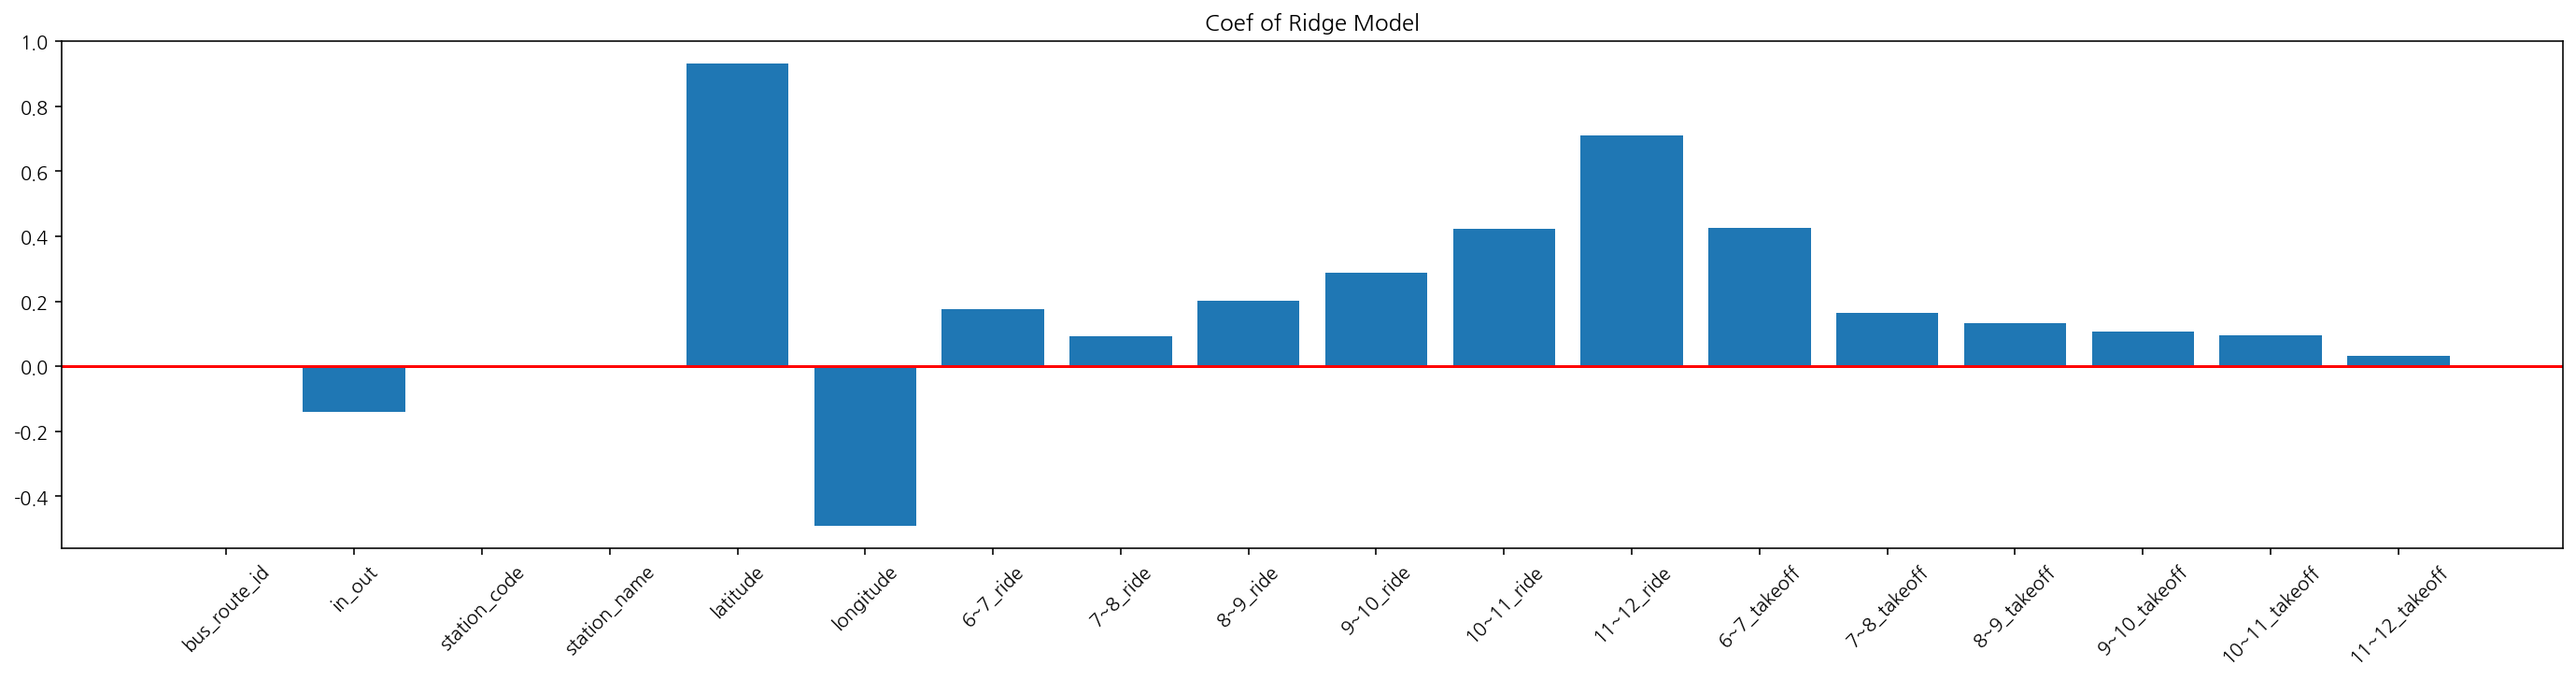

In [156]:
plt.figure(figsize=(24,5))

# Ridge의 Coef를 barplot으로 그린다. 
plt.bar( train.drop(drop_cols,1).columns, ridge.coef_   )

# y=0인 horizental한 선을 그린다. 
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title('Coef of Ridge Model');

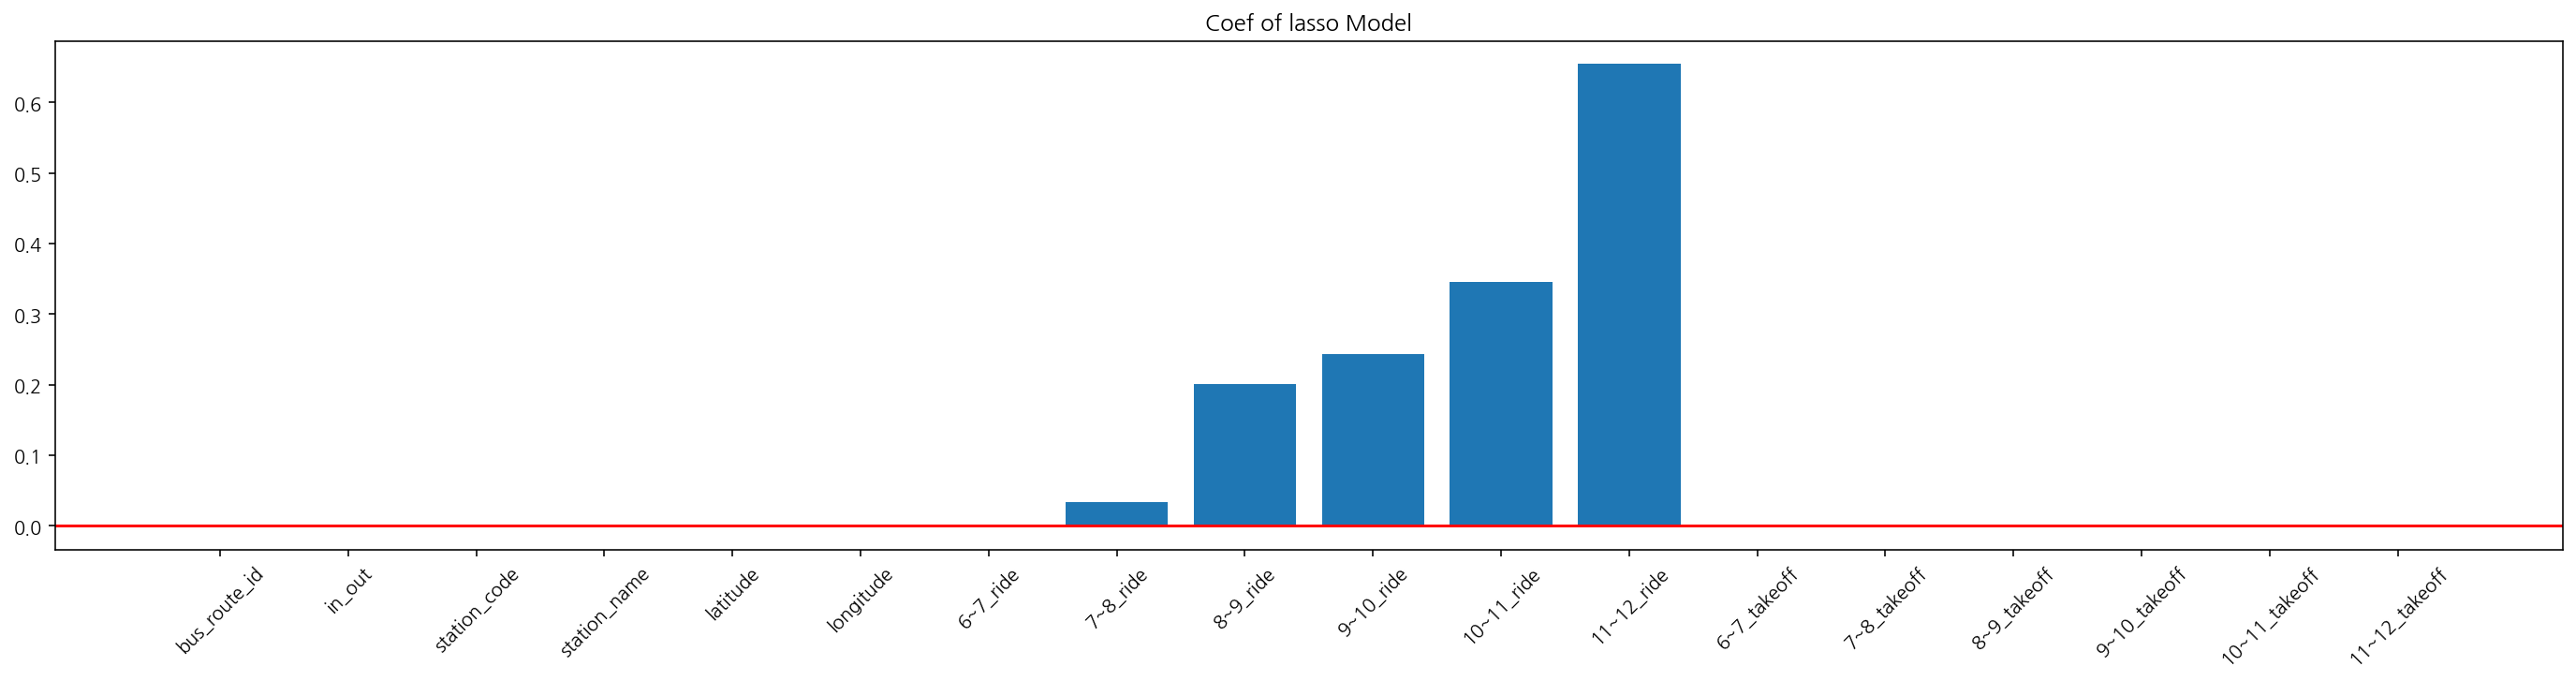

In [157]:
plt.figure(figsize=(24,5))

# lasso의 Coef를 barplot으로 그린다.
plt.bar( train.drop(drop_cols,1).columns,  lasso.coef_ )

# y=0인 horizental한 선을 그린다.
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of lasso Model");

In [158]:
# 상관관계를 살펴보도록 하자.
train.corr()[target_col].sort_values()

bus_route_id    -0.137364
station_code    -0.034048
longitude       -0.021368
id              -0.000544
in_out           0.022116
station_name     0.054216
latitude         0.079261
6~7_takeoff      0.178353
7~8_takeoff      0.219430
6~7_ride         0.262173
8~9_takeoff      0.274360
10~11_takeoff    0.290691
9~10_takeoff     0.295875
11~12_takeoff    0.313540
7~8_ride         0.371751
8~9_ride         0.445316
9~10_ride        0.494085
10~11_ride       0.512666
11~12_ride       0.569747
18~20_ride       1.000000
Name: 18~20_ride, dtype: float64

### Tree-based Model

- random forest 
    - 선형 모델과 비슷하게 정오 즈음의 탑승 승객수가 중요한 변수라고 판단
    - 선형모델과 다르게 bus route id에 대해서 높은 중요도를 보임 
- light gbm
    - 가장 좋은 성능을 보인 모델
    - 공간적 정보를 갖는 bus_route_id, station_code, station_name, latitude, longitude의 중요도가 다른 모델보다 높은 것을 확인 가능
    - 하차 승객수 보다는 승차 승객수의 변수 중요도가 더 높은 것으로 보임

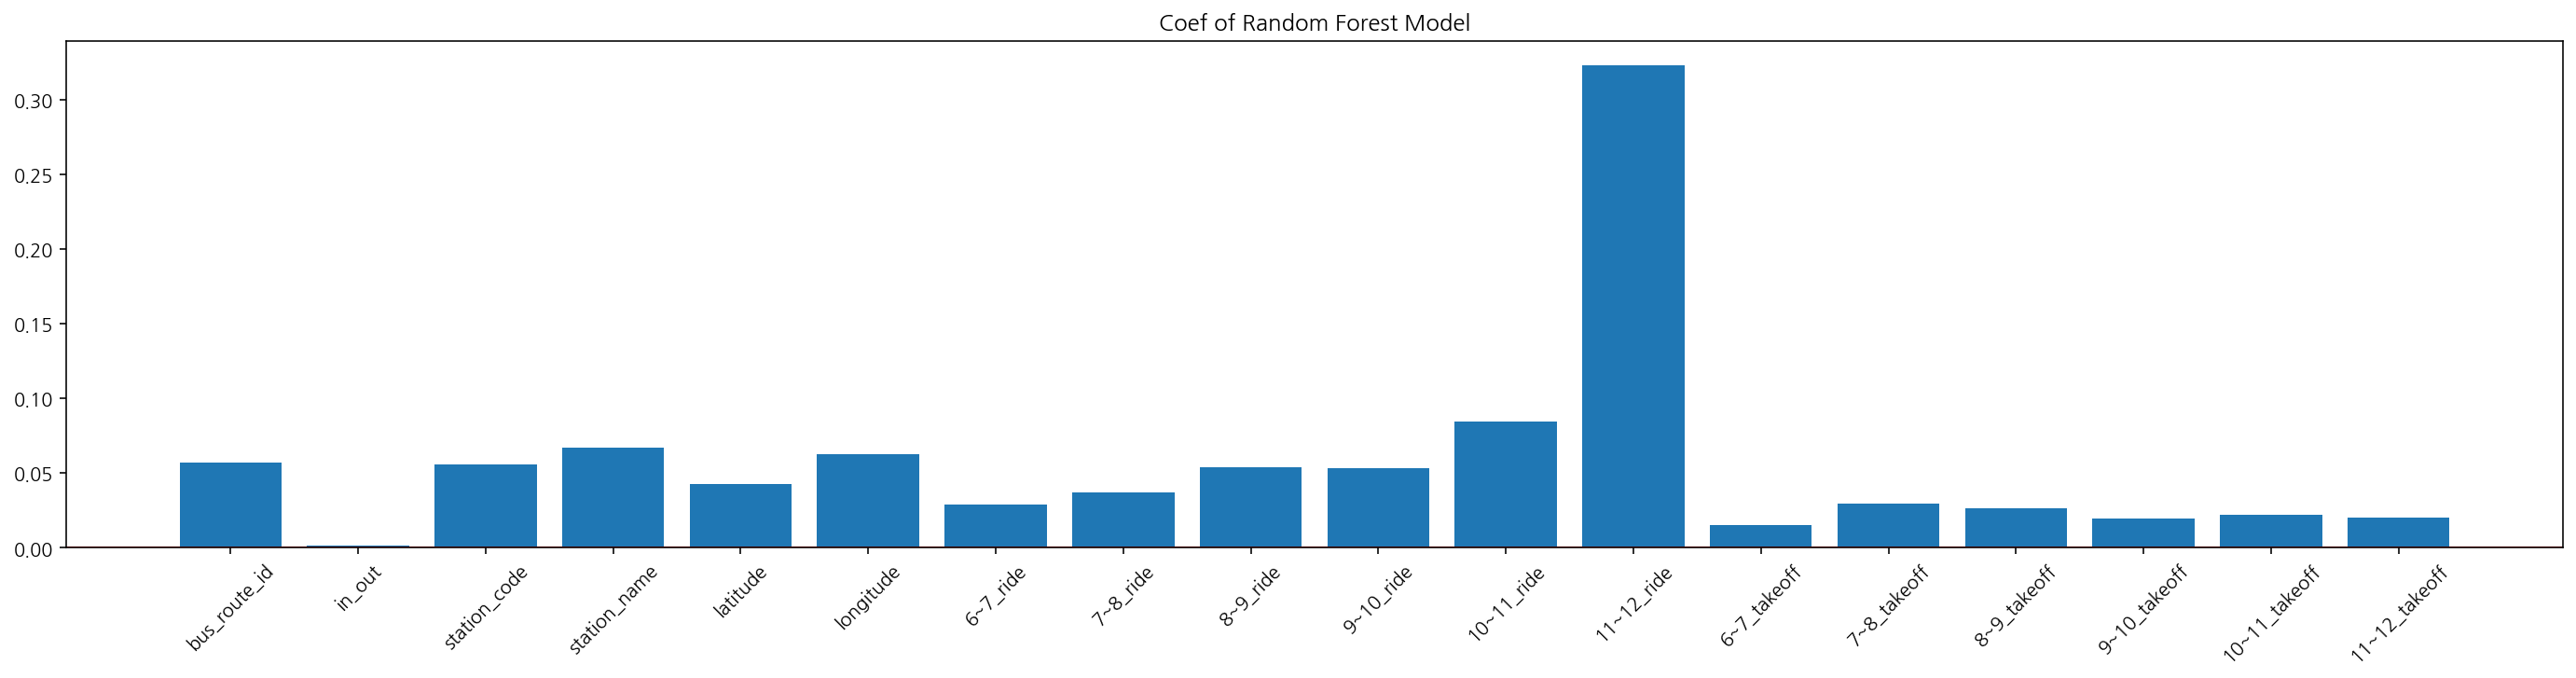

In [159]:
plt.figure(figsize=(24,5))

# Random Forest의 Feature Importances를 barplot으로 그린다. 
plt.bar( train.drop(drop_cols, 1).columns, rf.feature_importances_ )

# y=0인 horizental한 선을 그린다.
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of Random Forest Model");

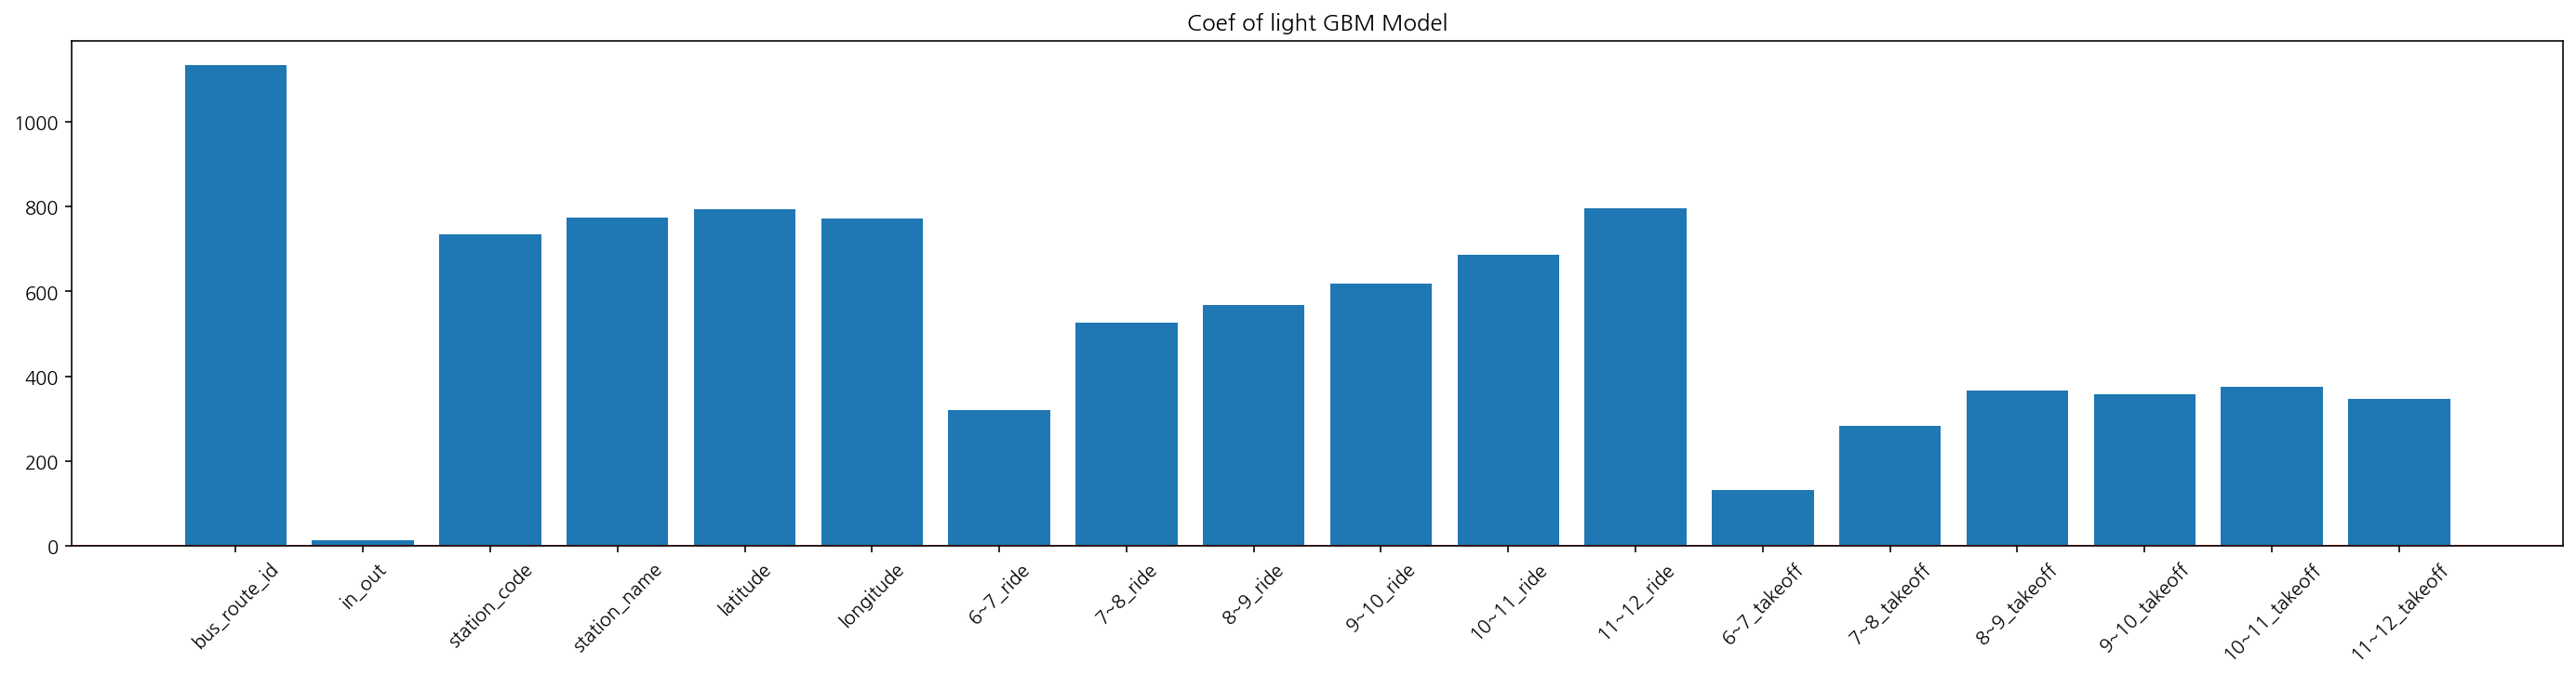

In [160]:
plt.figure(figsize=(24,5))

# lgbm의 Feature Importances를 barplot으로 그린다.
plt.bar( train.drop(drop_cols,1).columns,  model.feature_importance() )

# y=0인 horizental한 선을 그린다.
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of light GBM Model");

### PDP PLOT

다음으로 PDP(Partial Dependency Plot)을 통하여 특정 칼럼의 값이 변할 때 Target Variable이 어떤 식으로 영향을 받는지 살펴보도록 합시다.

In [161]:
# 전체 데이터를 사용할 시 너무 많은 시간이 소요되어 일부 샘플만 사용하도록 하겠습니다.
sample = train.drop(drop_cols,1).sample(1000)

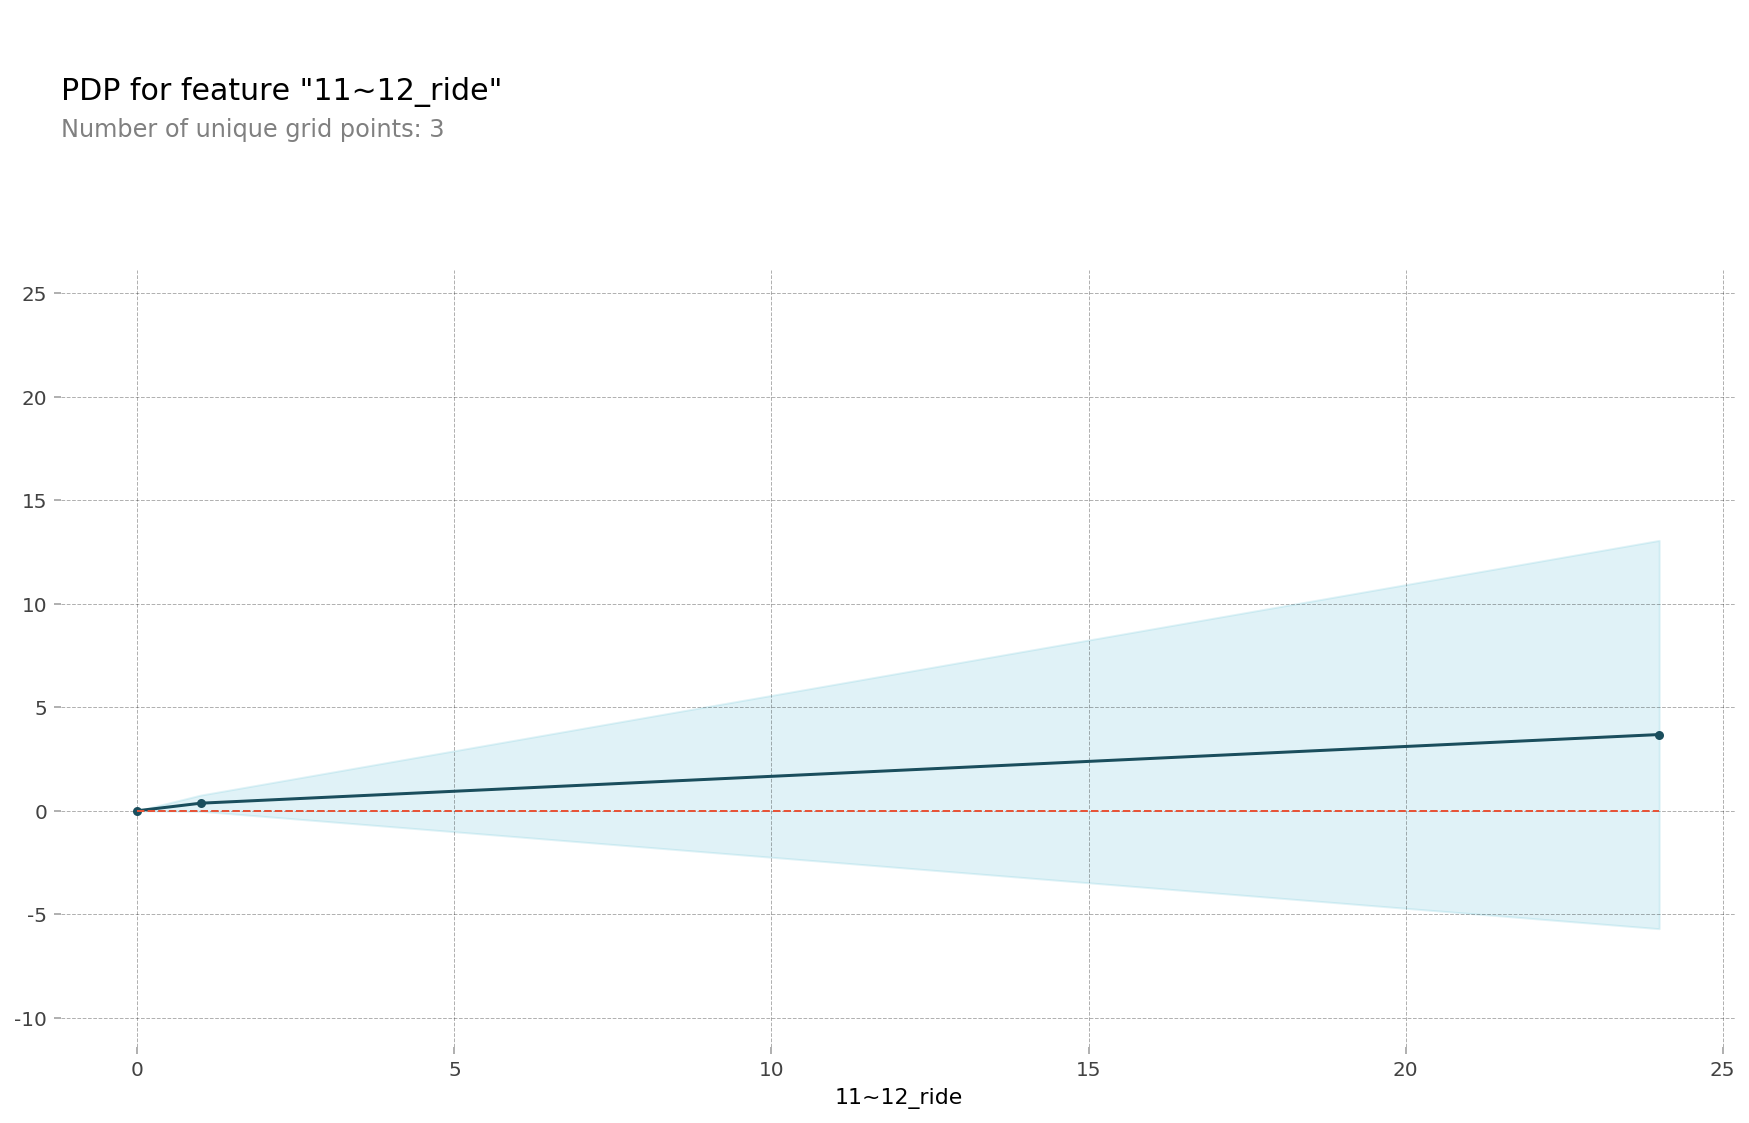

In [162]:
# PDP Plot For 11~12_ride
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), #컬럼의 이름 
    feature='11~12_ride')

fig, axes = pdp.pdp_plot(pdp_, '11~12_ride')

# 해당 피처가 변함에 따라 타겟이 어떻게 변하는가 
# 11~12시 탑승 승객수가 많은 곳일수록 퇴근 시간에 타는 승객수가 많을 것이다. 
# 폭이 작을수록 예측값에 대한 편차가 적다. = 신뢰도가 높다 

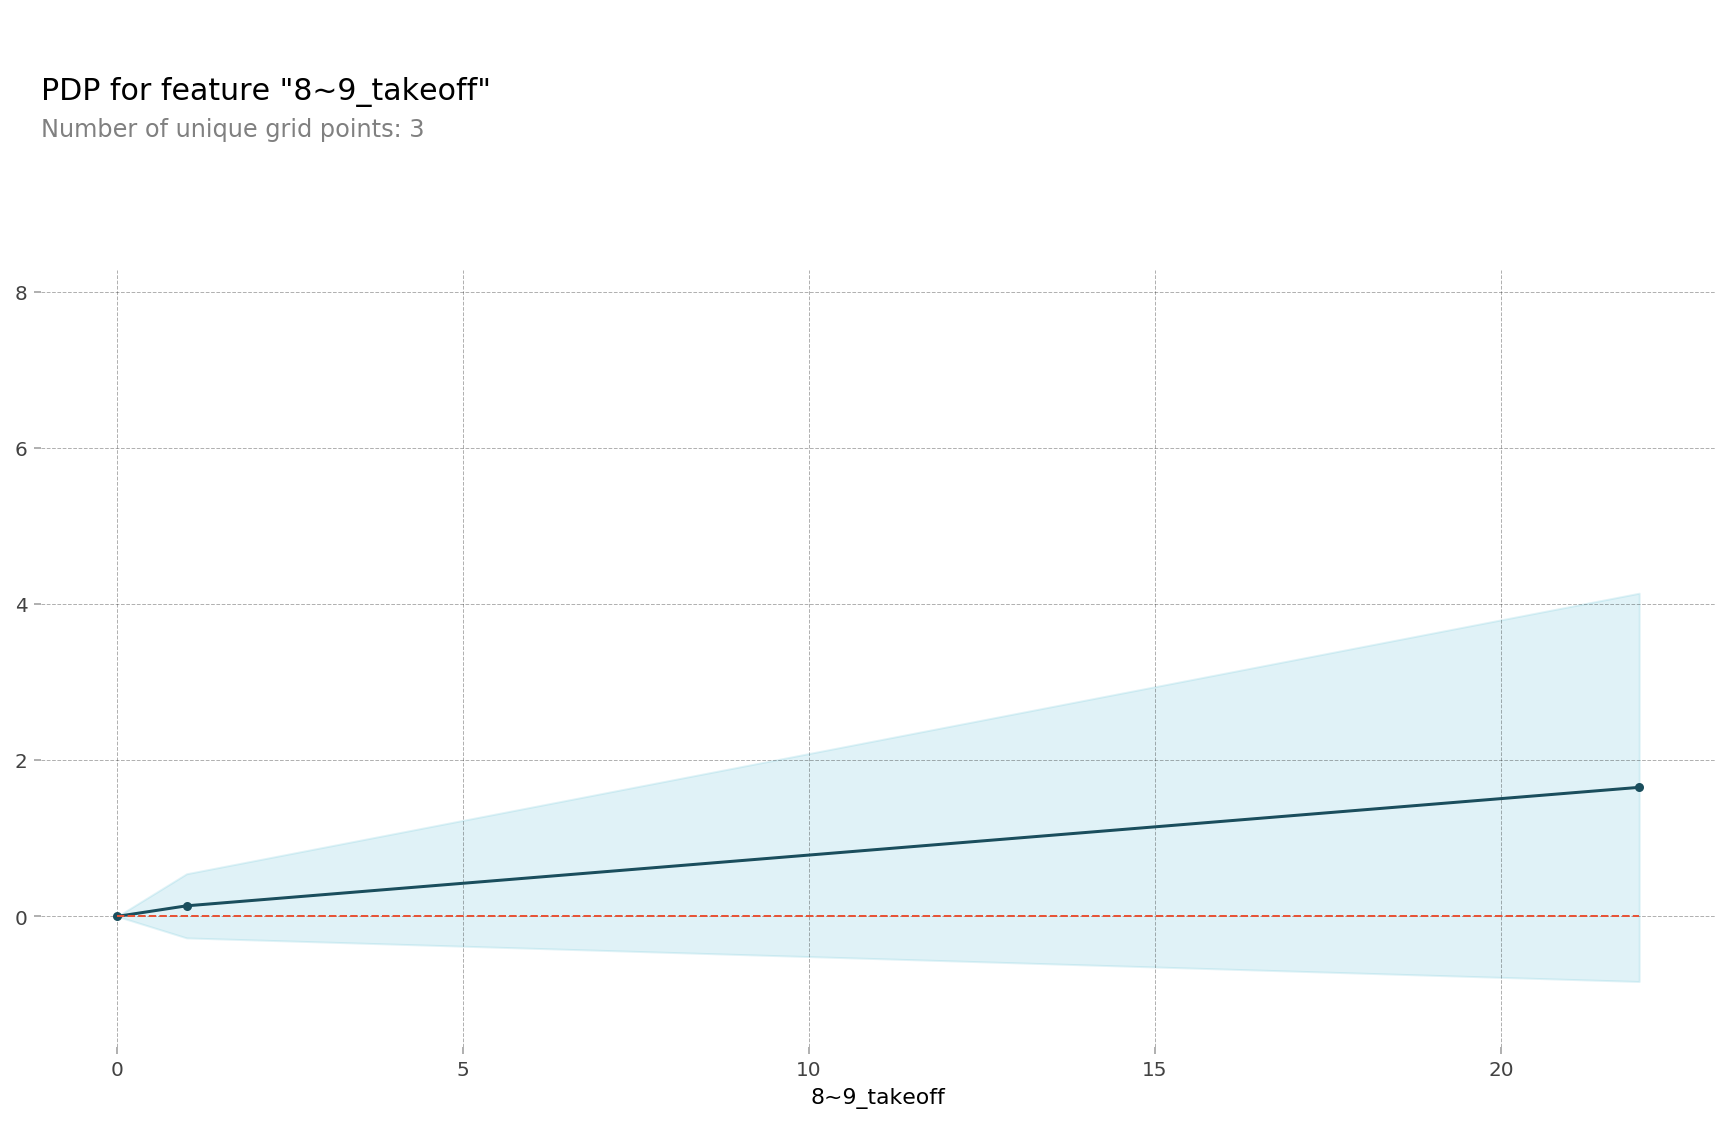

In [163]:
# PDP Plot For 8~9_takeoff
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), feature='8~9_takeoff'
)
fig, axes = pdp.pdp_plot(pdp_, '8~9_takeoff')

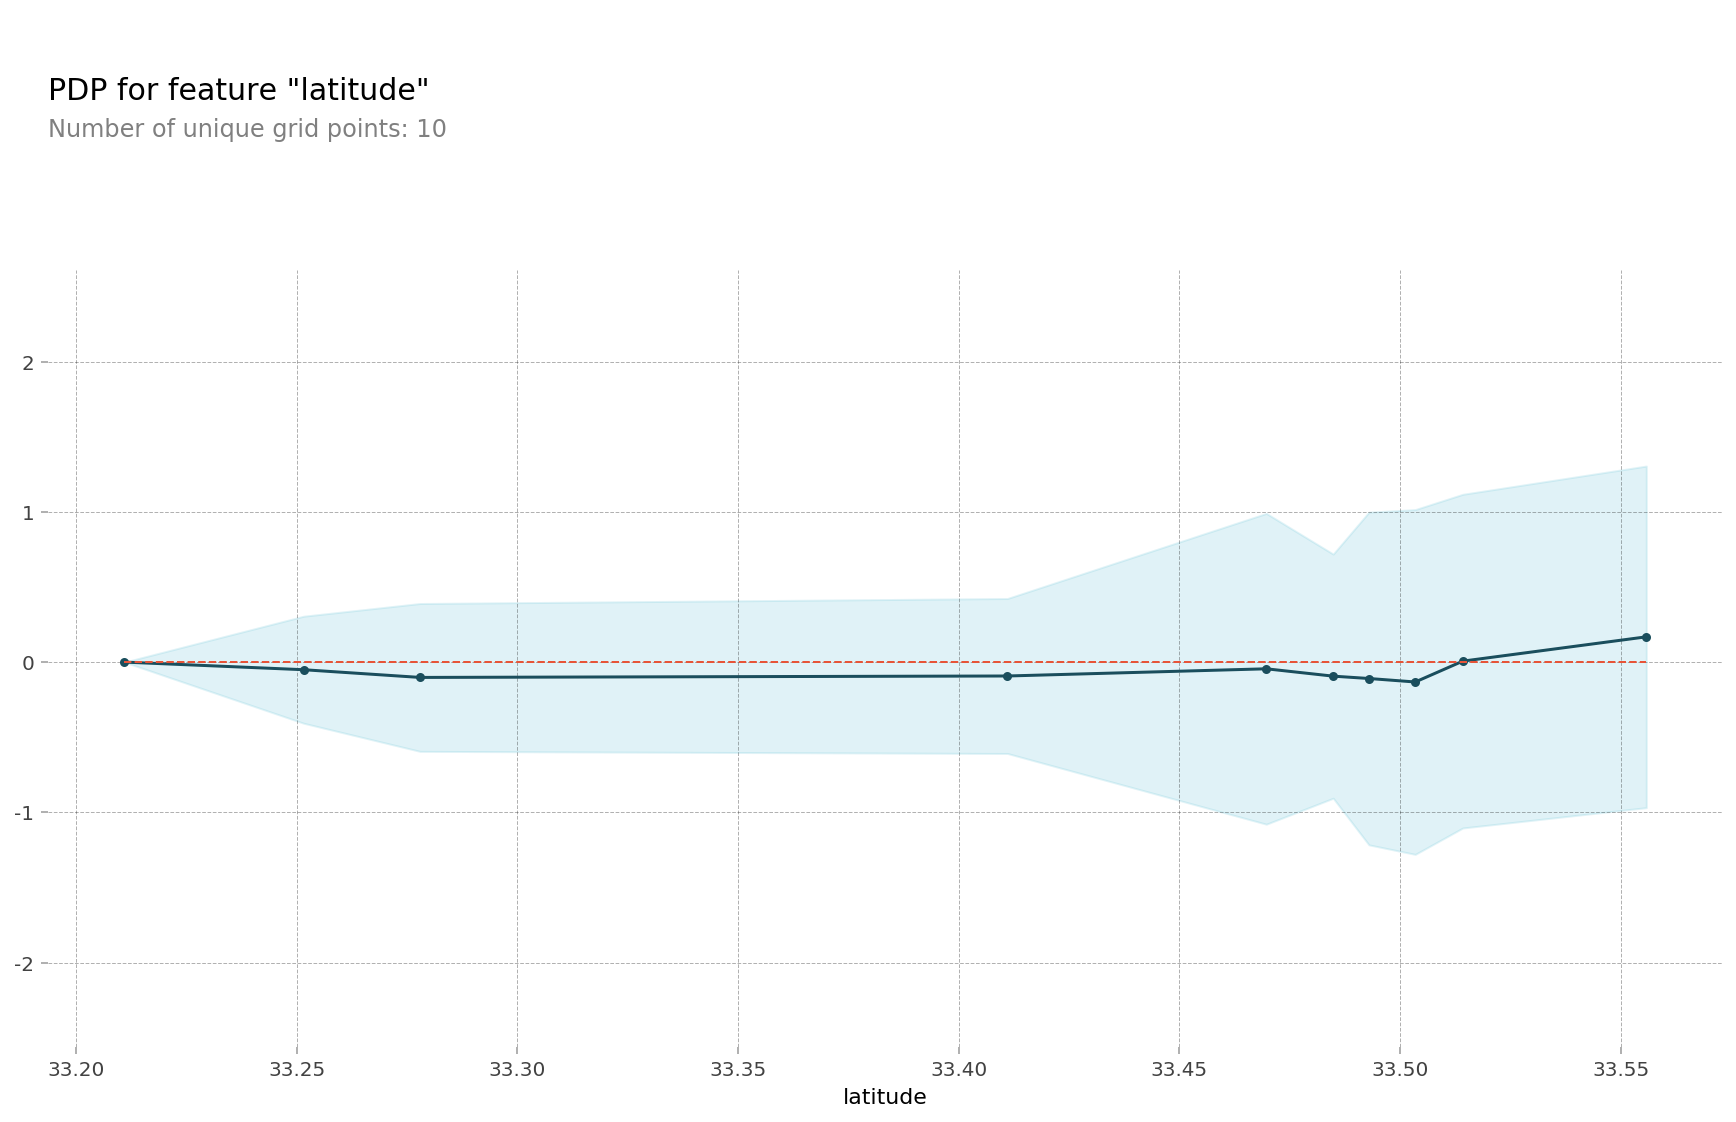

In [164]:
# PDP Plot For latitude
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), feature='latitude'
)
fig, axes = pdp.pdp_plot(pdp_, 'latitude')

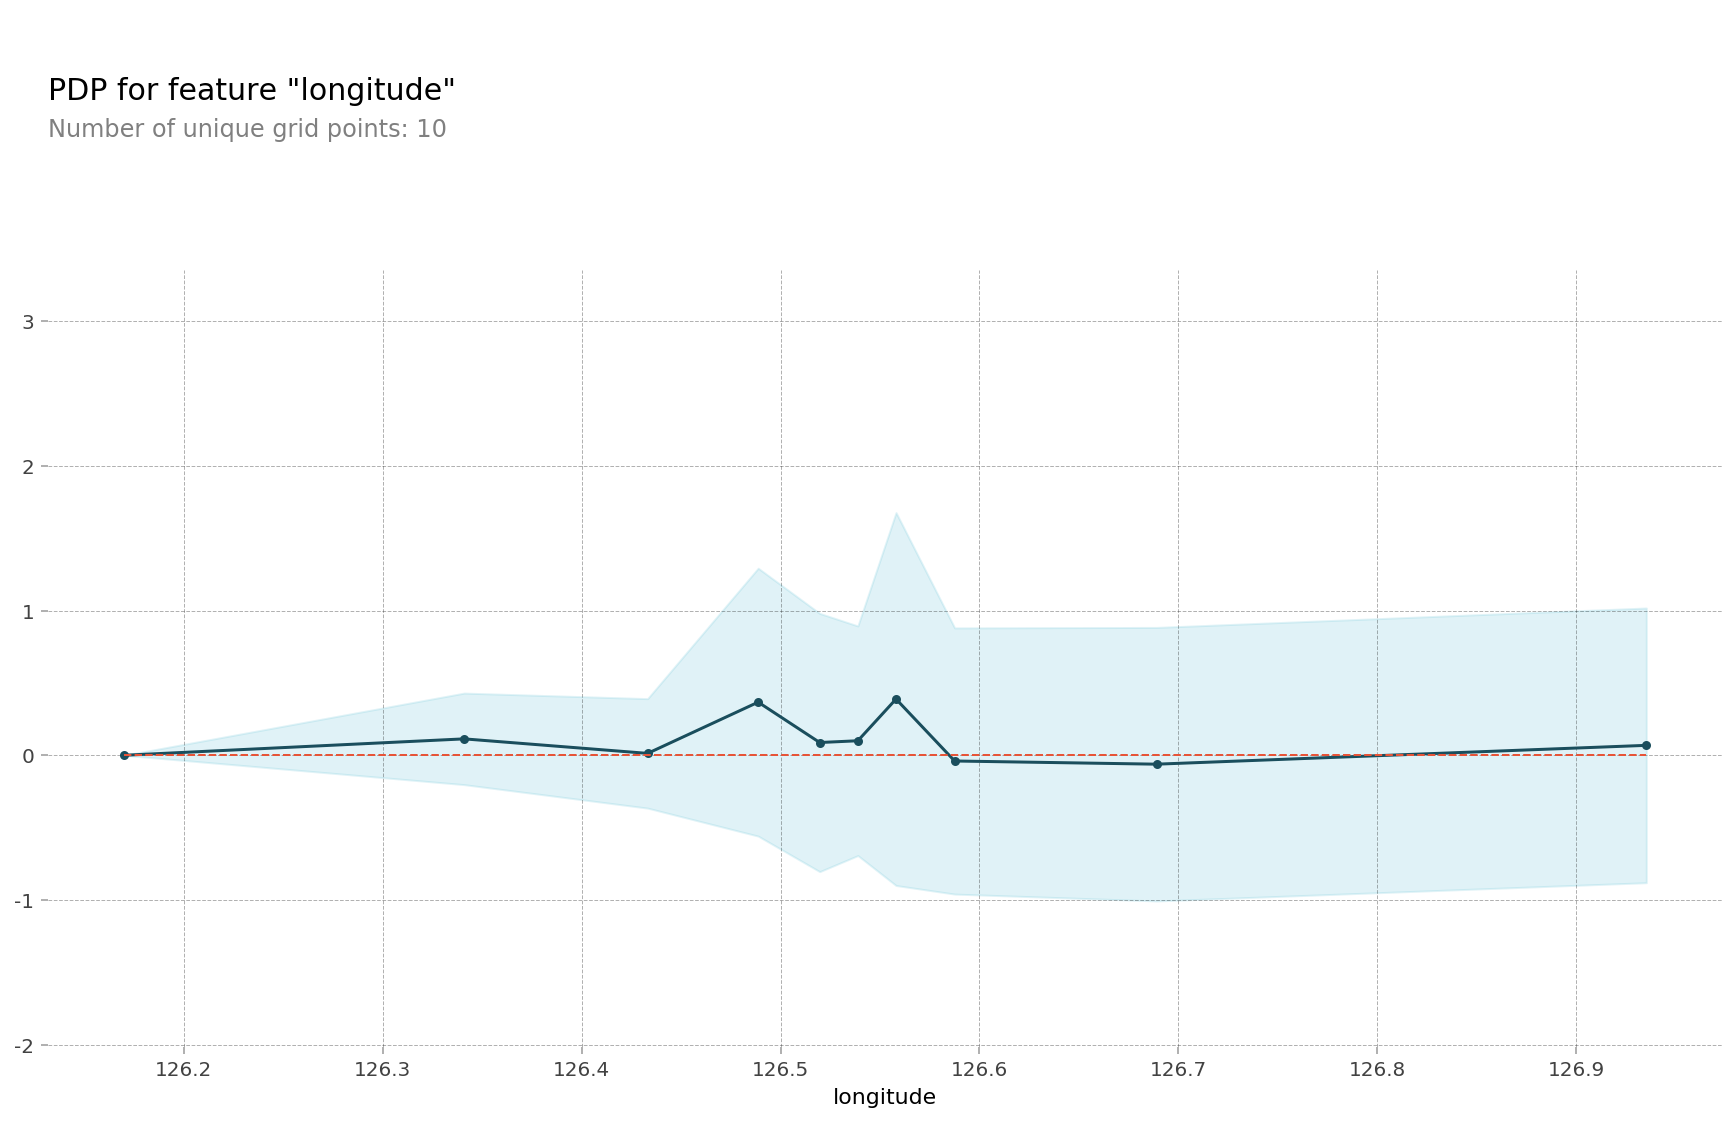

In [165]:
# PDP Plot For longitude
pdp_ = pdp.pdp_isolate(
    model= model, dataset=sample, model_features=list(sample), feature='longitude'
)
fig, axes = pdp.pdp_plot(pdp_, 'longitude')

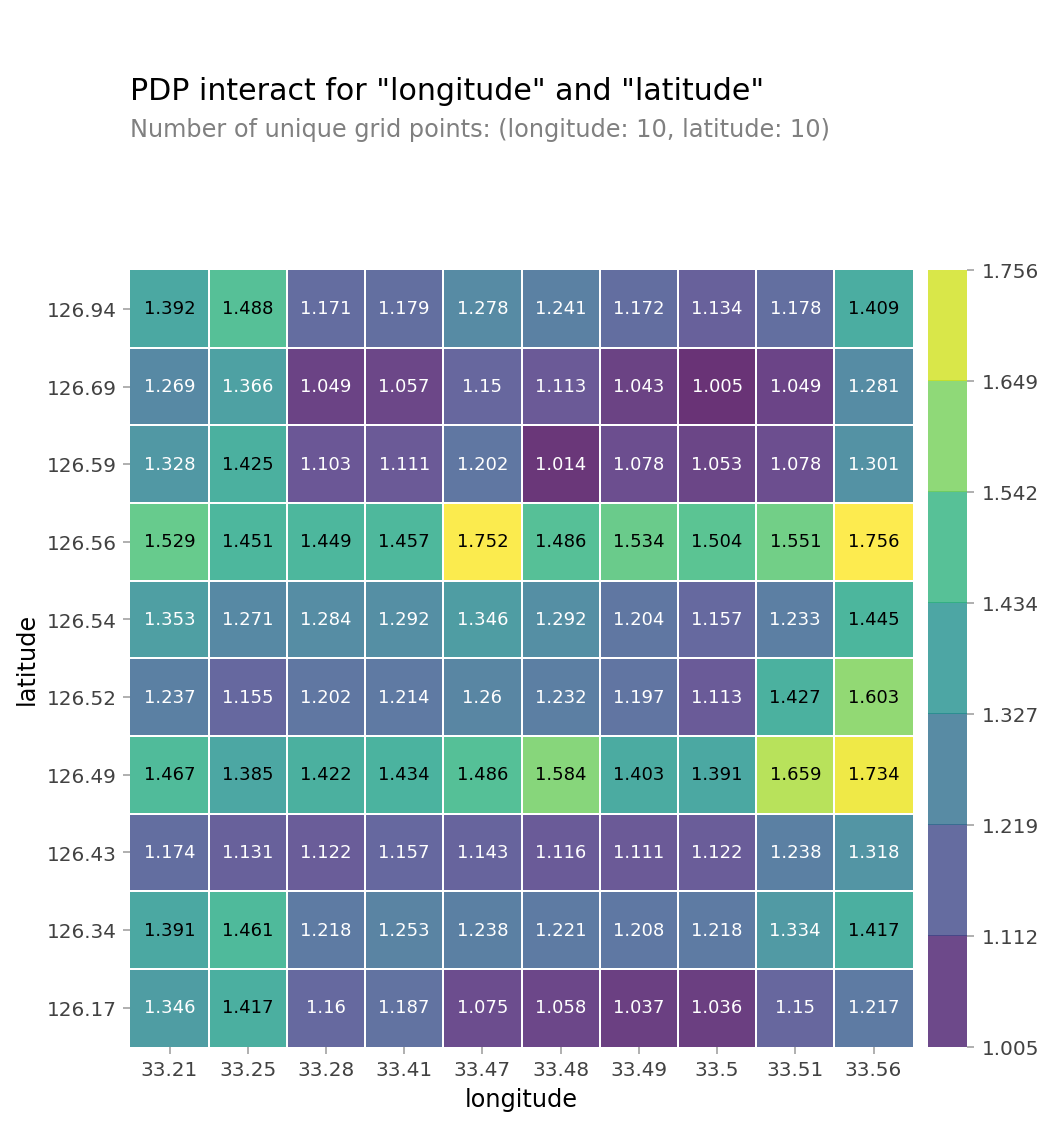

In [166]:
# Interactive PDP Plot For latitude,longitude
pdp_ = pdp.pdp_interact(
    model= model, dataset=sample, model_features=list(sample), features=['latitude','longitude']
)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_,
                                  feature_names=['longitude', 'latitude'],
                                  plot_type='grid',
                                  x_quantile=True,
                                  plot_pdp=False)

## 엔티티 개념을 활용한 피쳐 생성
**특정 노선**에서 **특정 버스**가 **특정 정류장**에서 **특정 날** 몇 명의 **승객**을 태웠는가 

- 버스 노선
    - 시간대별로 승객들이 얼마나 버스를 이용하였는가?(오전의 승하차 패턴 - Target Mean Encoding)
    - 날짜별로 오전 시간 승객들이 얼마나 버스를 이용하였는가?
- 버스 
    - 배차시간
- 승객
    - 승하차를 1시간 단위로 해야하는가?
- 정류장
    - 정류장의 순서 
    - 특정 정류장이 데이터에 얼마나 자주 등장하였는가?(고정적으로 타는 승객이 있는가 - Frequency Encoding)
    - 지역적 특성(상업 지구, 주거 지구, 학원가)등의 특징을 파악할 수 있는가?
        - 출근 시간에 승차가 많고 퇴근 시간에 하차가 많다면? -> 주거지구
        - 출근 시간엔 하차 내역이 많고 퇴근 시간에 승차가 많다면? -> 학교, 직장 근처 사무 지구
- 특정 날짜
    - 요일 정보
        - 평일과 주말의 승하차 패턴이 다르지 않을까?
            - 초중고 근처 정류장은 주말의 하차 승객 수가 급격히 줄어들 것
            - 같은 주중이라고 할지라도 금요일 밤의 패턴은 다르지 않을까?
    - 공휴일 정보
        - 추석의 영향은?
        - 10월에는 2개의 공휴일이 존재함(개천절, 한글날)
            - 같은 정도의 휴일이라고 할 수 있을까?
    - 날씨 정보
    - 시간대별로 승객들이 얼마나 버스를 이용하였는가?(오전의 승하차 패턴 - Mean Encoding / 퇴근 시간의 하차 패턴 - Target Mean Encoding)
- 제주도   

In [167]:
# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000 # boosting을 얼마나 돌릴지 지정한다 
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

In [198]:
df_bus = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/bus_bts.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/submission_sample.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/train.csv')

In [199]:
# categorical variable에 대해서는 Label-Encoding을 수행 
# --> One-Hot Encoding가 바람직하다고 생각되나 메모리 문제로 실행할 수 없음.
lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    
    # Label-Encoding을 fitting함
    lbl.fit( train[[col]].append(test[[col]]) )
    
    # train/test label_encoding한 값을 대입함
    train[col] = lbl.transform(train[col])
    test[col] = lbl.transform(test[col])

  0%|          | 0/4 [00:00<?, ?it/s]

In [170]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.30574	valid's rmse: 2.74915
[200]	train's rmse: 2.05878	valid's rmse: 2.70246
[300]	train's rmse: 1.90955	valid's rmse: 2.66699
[400]	train's rmse: 1.80317	valid's rmse: 2.65386
[500]	train's rmse: 1.72525	valid's rmse: 2.63958
[600]	train's rmse: 1.66145	valid's rmse: 2.63267
[700]	train's rmse: 1.60627	valid's rmse: 2.62778
Early stopping, best iteration is:
[660]	train's rmse: 1.62635	valid's rmse: 2.62755
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.32874	valid's rmse: 2.66488
[200]	train's rmse: 2.08707	valid's rmse: 2.63891
[300]	train's rmse: 1.94474	valid's rmse: 2.62898
[400]	train's rmse: 1.83968	valid's rmse: 2.61132
[500]	train's rmse: 1.75473	valid's rmse: 2.60217
[600]	train's rmse: 1.68747	valid's rmse: 2.59209
[700]	train's rmse: 1.63126	valid's rmse: 2.58362
[800]	train's rmse: 1.58192	valid's rmse:

In [200]:
# 승하차 간격을 2시간 간격으로 설정할 수는 없는가? (3시간으로 설정해도 ok -> 결국 실험의 영역)
dawn_ride_cols, dawn_takeoff_cols = ['6~7_ride','7~8_ride'], ['6~7_takeoff','7~8_takeoff']
morning_ride_cols, morning_takeoff_cols = ['8~9_ride','9~10_ride'], ['8~9_takeoff','9~10_takeoff']
noon_ride_cols, noon_takeoff_cols = ['10~11_ride','11~12_ride'], ['10~11_takeoff','11~12_takeoff']

def modify_terms(df): 
  # ride columns
  df['dawn_ride'] = df[dawn_ride_cols].sum(axis=1)
  df['morning_ride'] = df[morning_ride_cols].sum(axis=1)
  df['noon_ride'] = df[noon_ride_cols].sum(axis=1)

  # takeoff columns
  df['dawn_takeoff'] = df[dawn_takeoff_cols].sum(axis=1)
  df['morning_takeoff'] = df[morning_takeoff_cols].sum(axis=1)
  df['noon_takeoff'] = df[noon_takeoff_cols].sum(axis=1)

  # drop columns 
  drop_cols = dawn_ride_cols + morning_ride_cols + noon_ride_cols + dawn_takeoff_cols + morning_takeoff_cols + noon_takeoff_cols
  df = df.drop(drop_cols, 1)

  return df 

train = modify_terms(train)
test = modify_terms(test)

In [172]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.32718	valid's rmse: 2.75328
Early stopping, best iteration is:
[140]	train's rmse: 2.21752	valid's rmse: 2.74061
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.37316	valid's rmse: 2.63744
[200]	train's rmse: 2.14616	valid's rmse: 2.60199
[300]	train's rmse: 2.01191	valid's rmse: 2.59023
[400]	train's rmse: 1.92035	valid's rmse: 2.58024
[500]	train's rmse: 1.84405	valid's rmse: 2.57767
[600]	train's rmse: 1.77875	valid's rmse: 2.57152
Early stopping, best iteration is:
[565]	train's rmse: 1.79968	valid's rmse: 2.56977
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.34121	valid's rmse: 2.75993
[200]	train's rmse: 2.11551	valid's rmse: 2.71367
[300]	train's rmse: 1.98132	valid's rmse: 2.70279
Early stopping, best iteration is:
[347]	train's rmse: 1.93213	valid'

In [178]:
# 피쳐 중요도 확인 
data = { 'col' : model.feature_name(), 
         'imp' : model.feature_importance()}

df_imp = pd.DataFrame(data).sort_values(by='imp', ascending=False).reset_index(drop=True)
df_imp

,col,imp
0,bus_route_id,3934
1,noon_ride,3515
2,morning_ride,3322
3,longitude,2773
4,latitude,2764
5,station_name,2747
6,dawn_ride,2726
7,station_code,2702
8,morning_takeoff,2291
9,noon_takeoff,2101


### 날짜

- 요일 정보
    - 평일과 주말의 승하차 패턴이 다르지 않을까?
        - 초중고 근처 정류장은 주말의 하차 승객 수가 급격히 줄어들 것
        - 같은 주중이라고 할지라도 금요일 밤의 패턴은 다르지 않을까?
    - 공휴일 정보
        - 추석의 영향은?
        - 10월에는 2개의 공휴일이 존재함(개천절, 한글날)
            - 같은 정도의 휴일이라고 할 수 있을까?
    - 날씨 정보
    - 시간대별로 승객들이 얼마나 버스를 이용하였는가?(오전의 승하차 패턴 - Mean Encoding / 퇴근 시간의 하차 패턴 - Target Mean Encoding)


In [201]:
train['date'] = pd.to_datetime(train['date'].astype(str))
test['date'] = pd.to_datetime(test['date'].astype(str))

In [202]:
# 요일 정보 추가 
train['weekday'] = train['date'].dt.weekday
test['weekday'] = test['date'].dt.weekday

# 공휴일 정보 추가 
# -> EDA 필요 
holidays = [datetime(2019, 9 ,12), datetime(2019, 9, 13), datetime(2019, 9 ,14), datetime(2019, 10,3), datetime(2019, 10,9) ]
train['is_holiday'] = train['date'].apply(lambda x : x in holidays).astype(np.int8)
test['is_holiday'] = test['date'].apply(lambda x : x in holidays).astype(np.int8)

In [203]:
# Mean Encoding
# (1) 일자별로 dawn, morning, noon에 각각 몇몇의 승객이 탑승하였는가
# (2) 일자별로 dawn, morning, noon에 각각 몇몇의 승객이 하차하였는가
# - 기준 :
# - (1) bus_route_id
# - (2) bus_route_id , station_code
# - (3) station_code

# (1) bus_route_id 기준

# 탑승
train['avg_dawn_ride_bus_route_id'] = train.groupby(['date', 'bus_route_id'])['dawn_ride'].transform('mean')
train['avg_morning_ride_bus_route_id'] = train.groupby(['date', 'bus_route_id'])['morning_ride'].transform('mean')
train['avg_noon_ride_bus_route_id'] = train.groupby(['date', 'bus_route_id'])['noon_ride'].transform('mean')

test['avg_dawn_ride_bus_route_id'] = test.groupby(['date', 'bus_route_id'])['dawn_ride'].transform('mean')
test['avg_morning_ride_bus_route_id'] = test.groupby(['date', 'bus_route_id'])['morning_ride'].transform('mean')
test['avg_noon_ride_bus_route_id'] = test.groupby(['date', 'bus_route_id'])['noon_ride'].transform('mean')

# 하차 
train['avg_dawn_takeoff_bus_route_id'] = train.groupby(['date', 'bus_route_id'])['dawn_takeoff'].transform('mean')
train['avg_morning_takeoff_bus_route_id'] = train.groupby(['date', 'bus_route_id'])['morning_takeoff'].transform('mean')
train['avg_noon_takeoff_bus_route_id'] = train.groupby(['date', 'bus_route_id'])['noon_takeoff'].transform('mean')

test['avg_dawn_takeoff_bus_route_id'] = test.groupby(['date', 'bus_route_id'])['dawn_takeoff'].transform('mean')
test['avg_morning_takeoff_bus_route_id'] = test.groupby(['date', 'bus_route_id'])['morning_takeoff'].transform('mean')
test['avg_noon_takeoff_bus_route_id'] = test.groupby(['date', 'bus_route_id'])['noon_takeoff'].transform('mean')

# (2) bus_route_id, station_code 기준
# train['avg_dawn_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('mean') 
# train['avg_morning_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('mean') 
# train['avg_noon_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('mean') 

# test['avg_dawn_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('mean') 
# test['avg_morning_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('mean') 
# test['avg_noon_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('mean') 

# (3) station_code 기준
# train['avg_dawn_ride_station_code'] = train.groupby(['date','station_code'])['dawn_ride'].transform('mean') 
# train['avg_morning_ride_bus_station_code'] = train.groupby(['date','station_code'])['morning_ride'].transform('mean') 
# train['avg_noon_ride_station_code'] = train.groupby(['date','station_code'])['noon_ride'].transform('mean') 

# test['avg_dawn_ride_station_code'] = test.groupby(['date','station_code'])['dawn_ride'].transform('mean') 
# test['avg_morning_ride_bus_station_code'] = test.groupby(['date','station_code'])['morning_ride'].transform('mean') 
# test['avg_noon_ride_station_code'] = test.groupby(['date','station_code'])['noon_ride'].transform('mean') 


In [186]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train # 승객에 대한 정보를 y_train 값으로 임시로 넣어줌 
    d = X_train.groupby(['station_code'])['label'].mean().to_dict() # 정류장별로 승객이 평균 몇 명 탔는지 
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.00336	valid's rmse: 2.52675
[200]	train's rmse: 1.78187	valid's rmse: 2.49772
[300]	train's rmse: 1.64639	valid's rmse: 2.47723
Early stopping, best iteration is:
[321]	train's rmse: 1.62216	valid's rmse: 2.4738
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.04421	valid's rmse: 2.32358
[200]	train's rmse: 1.8193	valid's rmse: 2.28644
[300]	train's rmse: 1.67692	valid's rmse: 2.26913
[400]	train's rmse: 1.57436	valid's rmse: 2.2538
[500]	train's rmse: 1.49306	valid's rmse: 2.24171
[600]	train's rmse: 1.42323	valid's rmse: 2.23465
[700]	train's rmse: 1.35851	valid's rmse: 2.23254
[800]	train's rmse: 1.30305	valid's rmse: 2.22767
Early stopping, best iteration is:
[814]	train's rmse: 1.29499	valid's rmse: 2.22617
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.

In [204]:
# 날씨 정보 
df_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/229255_bus_riders_at_rush_hour_data/jeju_weather_dataset', encoding='cp949')
df_weather = df_weather[['일시', '강수량(mm)']]
df_weather.columns = ['date', 'precipitation']

# date의 type을 string에서 datetime으로 변환
df_weather['date'] = pd.to_datetime( df_weather['date'] )

# 대회 기간에 해당하는 데이터만 사용하도록 함
df_weather = df_weather[(df_weather['date']>='2019-08-31 00:00:00')&(df_weather['date']<='2019-10-16 23:00:00')].reset_index(drop=True)

# 대회 규정상 해당 날짜의 15시까지 정보만 사용할 수 있음
df_weather['hour'] = df_weather['date'].dt.hour
df_weather['date'] = df_weather['date'].dt.date

# 전날의 강수량을 정보를 대입할 때 사용
df_prevday_weather = df_weather.groupby('date')['precipitation'].sum().reset_index()
df_prevday_weather.columns = ['prev_date', 'prevday_precipitation']

# 해당 날짜의 강수량을 구함 
df_weather = df_weather[df_weather['hour']<=15].reset_index(drop=True)

# 00~15시까지의 강수량을 피쳐로 사용 
df_weather = df_weather.groupby('date')['precipitation'].sum().reset_index()

# Train/Test-set과 join하기 위하여 column의 타입을 datetime으로 변환한다. 
df_prevday_weather['prev_date'] = pd.to_datetime( df_prevday_weather['prev_date'] )
df_weather['date'] = pd.to_datetime( df_weather['date'] )

In [205]:
# 전날짜에 대하여 Train/Test-set과 강수량 정보를 join

# Train/Test-set에 대하여 전날을 구함
train['prev_date'] = train['date'] - pd.Timedelta('1 day')
test['prev_date'] = test['date'] - pd.Timedelta('1 day')

train = pd.merge(train, df_prevday_weather , on ='prev_date',  how ='left')
test = pd.merge(test, df_prevday_weather , on ='prev_date',how ='left')

# prev_date 칼럼은 삭제해줌
train = train.drop('prev_date',1)
test = test.drop('prev_date',1)

# 해당 날짜에 대하여 Train/Test-set과 강수량 정보를 join
train = pd.merge( train, df_weather , on ='date', how='left')
test = pd.merge( test, df_weather , on ='date', how='left')

In [207]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.98892	valid's rmse: 2.50777
[200]	train's rmse: 1.75765	valid's rmse: 2.47466
[300]	train's rmse: 1.61907	valid's rmse: 2.46216
[400]	train's rmse: 1.52395	valid's rmse: 2.45348
[500]	train's rmse: 1.44409	valid's rmse: 2.45138
[600]	train's rmse: 1.37676	valid's rmse: 2.44578
[700]	train's rmse: 1.32027	valid's rmse: 2.44222
[800]	train's rmse: 1.26823	valid's rmse: 2.43823
[900]	train's rmse: 1.22221	valid's rmse: 2.43711
[1000]	train's rmse: 1.18108	valid's rmse: 2.43461
Early stopping, best iteration is:
[1022]	train's rmse: 1.17186	valid's rmse: 2.43394
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 2.02505	valid's rmse: 2.31029
[200]	train's rmse: 1.7867	valid's rmse: 2.26391
[300]	train's rmse: 1.64805	valid's rmse: 2.24587
[400]	train's rmse: 1.54749	valid's rmse: 2.23398
[500]	train's rmse: 1.4668	valid's rmse:

### 버스 노선

- 해당 정거장이 특정 노선 중 몇 번째 정거장인가?
    - 해당 정거장에는 몇 개의 정거장이 있는가?
    - bus_route_id 별 station_code 순으로 버스가 정차하는 것처럼 보임
- 노선을 numeric type으로 학습시키는 것이 적합한가?
    - categorical vairable로 학습시킨다면?

In [208]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,dawn_ride,morning_ride,noon_ride,dawn_takeoff,morning_takeoff,noon_takeoff,weekday,is_holiday,avg_dawn_ride_bus_route_id,avg_morning_ride_bus_route_id,avg_noon_ride_bus_route_id,avg_dawn_takeoff_bus_route_id,avg_morning_takeoff_bus_route_id,avg_noon_takeoff_bus_route_id,prevday_precipitation,precipitation
0,0,2019-09-01,0,1,322,1489,33.48990,126.49373,0.0,1.0,7.0,8.0,0.0,0.0,0.0,6,0,1.28,2.24,2.72,0.16,0.32,1.88,0.0,0.6
1,1,2019-09-01,0,1,335,1831,33.48944,126.48508,5.0,5.0,6.0,11.0,0.0,0.0,0.0,6,0,1.28,2.24,2.72,0.16,0.32,1.88,0.0,0.6
2,2,2019-09-01,0,1,408,1413,33.48181,126.47352,2.0,2.0,2.0,0.0,0.0,0.0,0.0,6,0,1.28,2.24,2.72,0.16,0.32,1.88,0.0,0.6
3,3,2019-09-01,0,0,1448,1438,33.50577,126.49252,53.0,17.0,32.0,30.0,0.0,0.0,0.0,6,0,1.28,2.24,2.72,0.16,0.32,1.88,0.0,0.6
4,4,2019-09-01,0,0,1510,1583,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,0,1.28,2.24,2.72,0.16,0.32,1.88,0.0,0.6


In [209]:
# 해당 딕셔너리에 bus_route_id 별 정차 순서를 구하도록 함
bus_route_sequence = {}

# 모든 bus_route_id 수집 
combined = train.append(test, ignore_index=True)
all_bus_route_ids = set(combined['bus_route_id'])

for bus_route_id in tqdm_notebook( all_bus_route_ids ) :
    # bus_route_id별 station_code를 오름차순으로 순서매김함
    df_bus_route = combined[combined['bus_route_id']==bus_route_id]
    sorted_station_codes = np.unique(df_bus_route['station_code'])
    
    # dictionary에 해당 정류장이 몇번째 정차 정류장인지 기입
    bus_route_sequence[bus_route_id] = {station_code: ind for ind, station_code in enumerate( list(sorted_station_codes) )}

  0%|          | 0/631 [00:00<?, ?it/s]

In [222]:
# 몇 번째 정류장인지를 피쳐로 생성 
train['nth_station'] = train[['bus_route_id', 'station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)
test['nth_station'] = test[['bus_route_id', 'station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)

In [225]:
# 해당 bus_route_id에는 몇 개의 정류장이 있는지 
bus_route_id_total_station_count_dict = combined.groupby('bus_route_id')['station_code'].nunique().to_dict()

train['bus_route_id_total_station_count'] = train['bus_route_id'].apply(lambda x : bus_route_id_total_station_count_dict.get(x))
test['bus_route_id_total_station_count'] = test['bus_route_id'].apply(lambda x : bus_route_id_total_station_count_dict.get(x))

In [228]:
# 뒤에서부터 몇 번째 정류장인지 
train['nth_station_backward'] = train['nth_station'] - train['bus_route_id_total_station_count']
test['nth_station_backward'] = test['nth_station'] - test['bus_route_id_total_station_count']

In [232]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.75289	valid's rmse: 2.35176
Early stopping, best iteration is:
[137]	train's rmse: 1.64643	valid's rmse: 2.33721
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.79312	valid's rmse: 2.13689
[200]	train's rmse: 1.55592	valid's rmse: 2.11103
Early stopping, best iteration is:
[242]	train's rmse: 1.48991	valid's rmse: 2.10712
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.75385	valid's rmse: 2.30077
[200]	train's rmse: 1.52184	valid's rmse: 2.27475
[300]	train's rmse: 1.39039	valid's rmse: 2.26805
Early stopping, best iteration is:
[298]	train's rmse: 1.39264	valid's rmse: 2.26774
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.75804	valid's rmse: 2.33279
[200]	train's rmse: 1.52563	valid's rmse: 2.292

### 정류장

- Kmeans등을 이용하여 정류장을 군집화 시킨다면?
- 위경도 좌표를 통하여 행정동 or 법정동 정보를 수집할 수 있다면?

In [233]:
# 중복되지 않는 위경도 값들을 수집함
combined = train[['latitude', 'longitude']].append(test[['latitude', 'longitude']])
combined = combined.drop_duplicates()

# kmeans를 통하여 군집화 
kmeans = KMeans(n_clusters = int(sqrt(len(combined))), random_state=1993)
kmeans.fit(combined)

train['station_code_kmeans'] = kmeans.predict(train[['latitude', 'longitude']])
test['station_code_kmeans'] = kmeans.predict(test[['latitude', 'longitude']])

In [234]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.74036	valid's rmse: 2.34768
Early stopping, best iteration is:
[139]	train's rmse: 1.63143	valid's rmse: 2.33906
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.77957	valid's rmse: 2.15445
[200]	train's rmse: 1.54419	valid's rmse: 2.14345
[300]	train's rmse: 1.40646	valid's rmse: 2.13406
Early stopping, best iteration is:
[311]	train's rmse: 1.39474	valid's rmse: 2.13285
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.75307	valid's rmse: 2.30793
[200]	train's rmse: 1.52079	valid's rmse: 2.27812
Early stopping, best iteration is:
[192]	train's rmse: 1.53371	valid's rmse: 2.27501
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.75665	valid's rmse: 2.30983
[200]	train's rmse: 1.52562	valid's rmse: 2.269

## Feature 선택/제거 
* Boruta
* Target Permutation 
* Dropping High Correlation : Correlation이 99이상이면 제거, 제거한후 성능 비교 후 최종 결정 
* RFE (Recursive Feature Elimination) 
  * 하나씩 피처를 제거하면서 성능 비교 
  * 제거한게 좋냐 vs 좋지 않느냐 

In [235]:
lgbm_param = {'objective': 'rmse',
             'boosting_type': 'gbdt',
             'random_state': 1993,
             'learning_rate': 0.1,
             'subsample': 0.7,
             'tree_learner': 'serial',
             'colsample_bytree': 0.78,
#              'early_stopping_rounds': 50,
             'subsample_freq': 1,
             'reg_lambda': 7,
             'reg_alpha': 5,
             'num_leaves': 96,
             'seed': 1993}

In [237]:
reg_model = lgbm.LGBMRegressor(**lgbm_param)

# RFE(Recursive Feature Elimination)
rfe = RFECV(estimator=reg_model, step=1, # 한 번 학습이 진행될 때마다 몇 개의 피처를 제거하고 싶으냐? 큰 숫자를 선택하면 학습시간 단축 
            cv=KFold(n_splits=5, shuffle=True, random_state=231), scoring='neg_mean_squared_error', verbose=2)
rfe.fit(train.drop(drop_cols,1), train_label)

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.


RFECV(cv=KFold(n_splits=5, random_state=231, shuffle=True),
      estimator=LGBMRegressor(colsample_bytree=0.78, num_leaves=96,
                              objective='rmse', random_state=1993, reg_alpha=5,
                              reg_lambda=7, seed=1993, subsample=0.7,
                              subsample_freq=1, tree_learner='serial'),
      scoring='neg_mean_squared_error', verbose=2)

In [238]:
df_rank = pd.DataFrame(data = {'col' : list(train.drop(drop_cols,1)), 'imp' : rfe.ranking_}) # 랭킹이 1에 가까울수록 의미 있는 피처다 
use_cols = list(df_rank[df_rank['imp'] == 1]['col']) 

In [240]:
lgbm_param = {'objective': 'rmse',
             'boosting_type': 'gbdt',
             'random_state': 1993,
             'learning_rate': 0.1,
             'subsample': 0.7,
             'tree_learner': 'serial',
             'colsample_bytree': 0.78,
             'early_stopping_rounds': 50,
             'subsample_freq': 1,
             'reg_lambda': 7,
             'reg_alpha': 5,
             'num_leaves': 96,
             'seed': 1993}

In [241]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train[use_cols], y_train)
    dvalid = lgbm.Dataset(X_valid[use_cols], y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid[use_cols])
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.75777	valid's rmse: 2.35688
[200]	train's rmse: 1.52646	valid's rmse: 2.34582
[300]	train's rmse: 1.39089	valid's rmse: 2.33528
Early stopping, best iteration is:
[302]	train's rmse: 1.38892	valid's rmse: 2.33496
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.7989	valid's rmse: 2.16992
[200]	train's rmse: 1.56383	valid's rmse: 2.15231
Early stopping, best iteration is:
[240]	train's rmse: 1.50043	valid's rmse: 2.14869
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.76513	valid's rmse: 2.32654
[200]	train's rmse: 1.53325	valid's rmse: 2.29655
[300]	train's rmse: 1.40288	valid's rmse: 2.28792
[400]	train's rmse: 1.31201	valid's rmse: 2.28522
[500]	train's rmse: 1.24289	valid's rmse: 2.28305
[600]	train's rmse: 1.18573	valid's rmse: 2.27828
Early stopping, best

## Test-set 값 예측 (Ensemble)

In [242]:
# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'learning_rate':0.01,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.68,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

n_rounds = 100000
cat_params = {
        'n_estimators': n_rounds,
        'learning_rate': 0.08, # 0.005로 하면 폴드당 2시간 걸림 
        'eval_metric': 'RMSE', 
        'loss_function': 'RMSE',
        'random_seed': 42, 
        'metric_period': 500, # 메트릭스 평가 주기 
        'od_wait': 500, # 오버피팅을 방지 할 때 
        'task_type': 'GPU', # 무조건 GPU를 사용하는게 좋음. settings > accelerator를 GPU로 설정 
       'l2_leaf_reg' : 3, # 얼마나 많이 regularization을 줄것인가. 2~3
        'depth': 8, # 보통 5~10 정도 
    }

In [243]:
target_col = '18~20_ride'
drop_cols = ['date','id',target_col]
train_label = train[target_col]

In [244]:
# 형식을 맞춰주기 위해서 Test-set에 '18~20_ride' columns을 만들어줌
test[target_col] = np.NaN

In [247]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))
lgbm_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test.drop(drop_cols, 1))
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 3.02832	valid's rmse: 3.07656
[200]	train's rmse: 2.44893	valid's rmse: 2.61618
[300]	train's rmse: 2.20433	valid's rmse: 2.459
[400]	train's rmse: 2.07505	valid's rmse: 2.40168
[500]	train's rmse: 1.98787	valid's rmse: 2.37225
[600]	train's rmse: 1.92107	valid's rmse: 2.35463
[700]	train's rmse: 1.86691	valid's rmse: 2.34302
[800]	train's rmse: 1.82279	valid's rmse: 2.33718
[900]	train's rmse: 1.78382	valid's rmse: 2.33224
[1000]	train's rmse: 1.74746	valid's rmse: 2.32641
[1100]	train's rmse: 1.71501	valid's rmse: 2.32323
[1200]	train's rmse: 1.68576	valid's rmse: 2.31939
[1300]	train's rmse: 1.65859	valid's rmse: 2.31672
[1400]	train's rmse: 1.63323	valid's rmse: 2.31355
[1500]	train's rmse: 1.61027	valid's rmse: 2.31166
[1600]	train's rmse: 1.58846	valid's rmse: 2.31103
[1700]	train's rmse: 1.56825	valid's rmse: 2.30873
[1800]	train's rmse: 1.54876	valid's rmse: 2.30801
[1900]

In [248]:
# 각 모델에 대한 oof 정의
cat_oof_train = np.zeros((train.shape[0]))
cat_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    # (5) CATBOOST
    print("---TRAINING CATBOOST---")
    
    # model 정의&학습
    model = CatBoostRegressor(**cat_params)
    
    model.fit( X_train, y_train, eval_set = (X_valid, y_valid), 
              cat_features  = ['bus_route_id','station_code', 'station_code_kmeans'],
              use_best_model=True,
              verbose=True)
    
    # local_valid/local_test에 대한 예측
    cat_valid_pred = model.predict(X_valid)
    cat_test_pred = model.predict(test.drop(drop_cols, 1))
        
    cat_oof_train[val_ind] = cat_valid_pred
    cat_oof_test += cat_test_pred/ n_splits
    print('='*80)
    
print(f"<CATBOOST> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, cat_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING CATBOOST---
0:	learn: 4.5380824	test: 4.4306551	best: 4.4306551 (0)	total: 51.4ms	remaining: 1h 25m 37s
500:	learn: 1.9458630	test: 2.4234457	best: 2.4234457 (500)	total: 18.4s	remaining: 1h 51s
1000:	learn: 1.7374907	test: 2.3683804	best: 2.3683399 (999)	total: 35.7s	remaining: 58m 52s
1500:	learn: 1.6057637	test: 2.3434642	best: 2.3433077 (1490)	total: 55.4s	remaining: 1h 33s
2000:	learn: 1.5104954	test: 2.3334114	best: 2.3331079 (1992)	total: 1m 14s	remaining: 1h 1m 3s
2500:	learn: 1.4356077	test: 2.3268342	best: 2.3268342 (2500)	total: 1m 33s	remaining: 1h 38s
3000:	learn: 1.3728601	test: 2.3220920	best: 2.3220725 (2999)	total: 1m 51s	remaining: 59m 49s
3500:	learn: 1.3176372	test: 2.3196005	best: 2.3196005 (3500)	total: 2m 14s	remaining: 1h 1m 47s
4000:	learn: 1.2679179	test: 2.3186669	best: 2.3179452 (3758)	total: 2m 33s	remaining: 1h 1m 21s
4500:	learn: 1.2233283	test: 2.3157834	best: 2.3156541 (4486)	total: 2m 51s	remaining: 1h 40s
5000:	learn: 1.1817428	test: 2.313

## 제출 파일 만들기

In [249]:
# 제출 파일 만들기
ensemble_pred = 0.5 * ( lgbm_oof_test+ cat_oof_test )
sample_submission[target_col] = np.clip( ensemble_pred, 0 , max(ensemble_pred) )

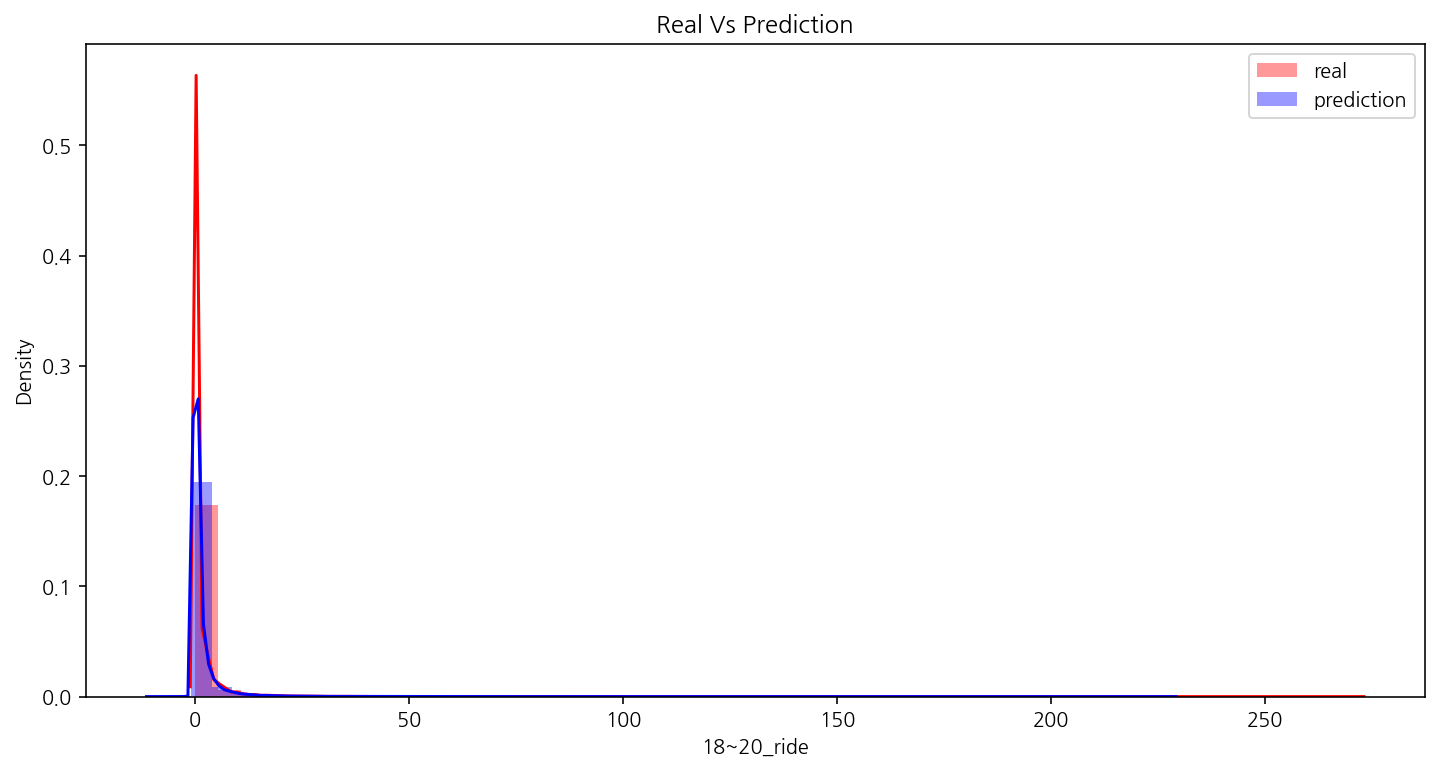

In [250]:
# Train-set의 실제값과 예측값 비교
plt.figure(figsize=(12,6))

sns.distplot( train_label, color='r' , label='real')
sns.distplot( 0.5*(lgbm_oof_train + cat_oof_train), color='b', label='prediction' )
plt.legend()
plt.title("Real Vs Prediction");

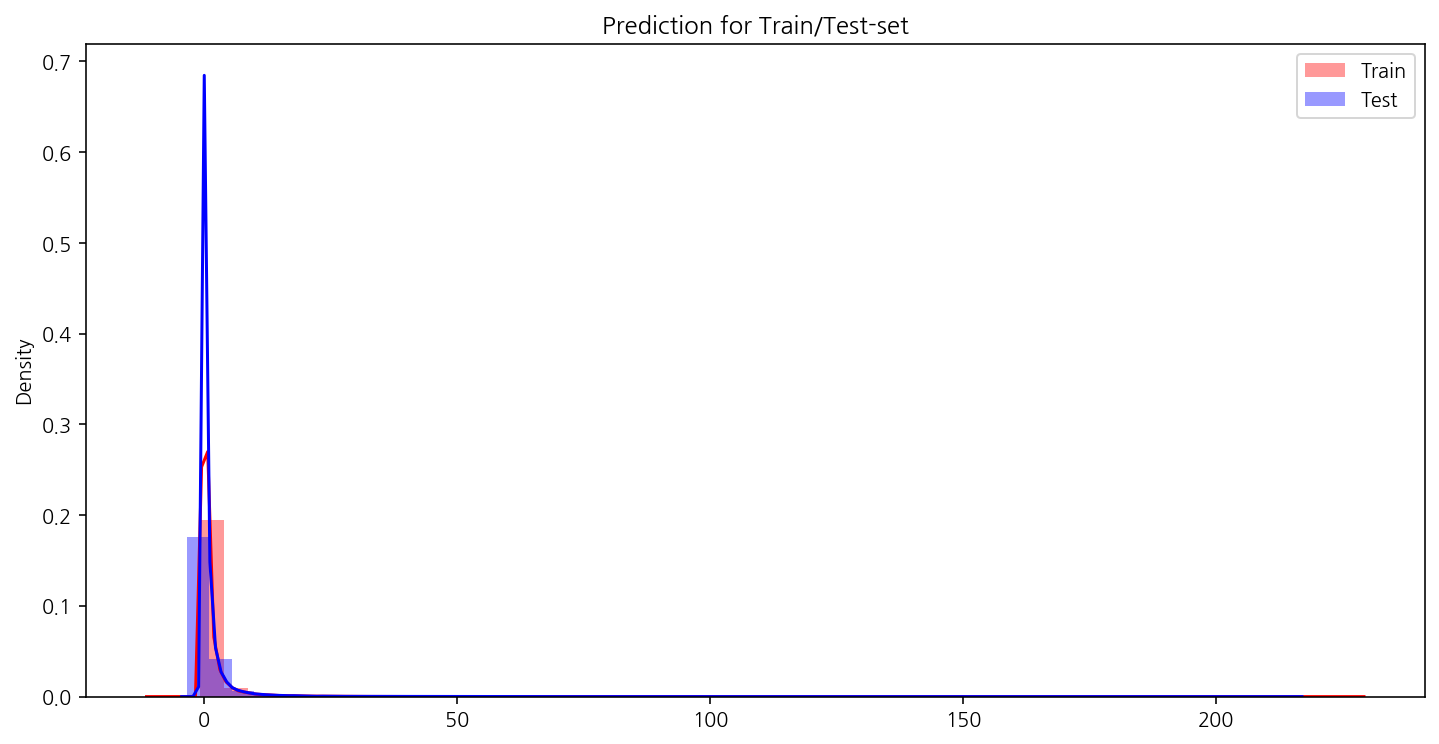

In [251]:
# Train-set/Test-set의  예측값 비교
plt.figure(figsize=(12,6))

sns.distplot( 0.5*(lgbm_oof_train + cat_oof_train), color='r' , label='Train')
sns.distplot( ensemble_pred, color='b', label='Test' )
plt.legend()
plt.title("Prediction for Train/Test-set");

In [252]:
from IPython.display import FileLink

sample_submission.to_csv('lgbm_catboost_ensemble.csv', index=False)

In [253]:
FileLink('lgbm_catboost_ensemble.csv')

/content/lgbm_catboost_ensemble.csv